In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


C:\Users\ankan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\ankan\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [10, 5]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

__Some functions__:

In [3]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [4]:
data = pd.read_csv('data.csv')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  6
Features :  ['Unnamed: 0' 'ID' 'Gene' 'Variation' 'Class' 'TEXT']


Unnamed: 0  ID    Gene             Variation  Class  \
0           0   0  FAM58A  Truncating_Mutations      1   
1           1   1     CBL                 W802*      2   
2           2   2     CBL                 Q249E      2   
3           3   3     CBL                 N454D      3   
4           4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...

In [5]:
data['TEXT'][67]

'genes encoding components pi3k akt mtor signaling axis frequently mutated cancer mutations characterized mtor gene mtor kinase using publicly available tumor genome sequencing data generated comprehensive catalog mtor pathway mutations cancer identifying 33 mtor mutations confer pathway hyperactivation mutations cluster six distinct regions c terminal half mtor occur multiple cancer types one cluster particularly prominent kidney cancer activating mutations affect mtor complex assembly subset reduces binding mtor inhibitor deptor mtorc1 signaling cells expressing various activating mutations remains sensitive pharmacological mtor inhibition partially resistant nutrient deprivation lastly cancer cell lines hyperactivating mtor mutations display heightened sensitivity rapamycin culture vivo xenografts suggesting mutations confer mtor pathway dependency keywords personalized mtor mutations biomarker deptor go introduction mammals pi3k akt mtor pathway regulates cell size mrna translation

In [6]:
y_true = data['Class'].values
data.Gene = data.Gene.str.replace('\s+', '_')
data.Variation = data.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.1)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1)

In [7]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

<h1> Response-coding of the Gene feature </h1>

In [8]:
from sklearn.externals import joblib

In [9]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [10]:
joblib.dump(train_gene_feature_responseCoding, 'response_gene_train.pkl')
joblib.dump(test_gene_feature_responseCoding , 'response_gene_test.pkl')
joblib.dump(cv_gene_feature_responseCoding, 'response_gene_cv.pkl')

['response_gene_cv.pkl']

<h1> Tfidf of text features </h1>

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
vect = TfidfVectorizer(ngram_range = (1,4), stop_words = "english", min_df = 3, max_features = 100000) #upto 4-grams
tfidf = vect.fit_transform(train_df['TEXT'])
tfidf_test = vect.transform(test_df['TEXT'])
tfidf_cv = vect.transform(cv_df['TEXT'])


tfidf_train = StandardScaler(with_mean = False).fit_transform(tfidf)

tfidf_test = StandardScaler(with_mean = False).fit_transform(tfidf_test)

tfidf_cv = StandardScaler(with_mean = False).fit_transform(tfidf_cv)

In [13]:
joblib.dump(tfidf_train, 'tfidf for text.pkl')
joblib.dump(tfidf_test, 'tfidf for text test.pkl')
joblib.dump(tfidf_cv, 'tfidf for text cv.pkl')

['tfidf for text cv.pkl']

In [14]:
train_text_features= vect.get_feature_names()


For values of alpha =  1e-05 The CV log loss is: 1.4942778820449512
For values of alpha =  0.0001 The CV log loss is: 1.465427898325258
For values of alpha =  0.001 The CV log loss is: 1.4505443196531742
For values of alpha =  0.01 The CV log loss is: 1.4403391037987467
For values of alpha =  0.1 The CV log loss is: 1.433042845710454
For values of alpha =  1 The CV log loss is: 1.3558401340357846
For values of alpha =  10 The CV log loss is: 1.1259963098985137
For values of alpha =  100 The CV log loss is: 1.2501658968453964
For values of alpha =  1000 The CV log loss is: 1.481197818356071
For values of alpha =  10000 The CV log loss is: 1.5599436426352626


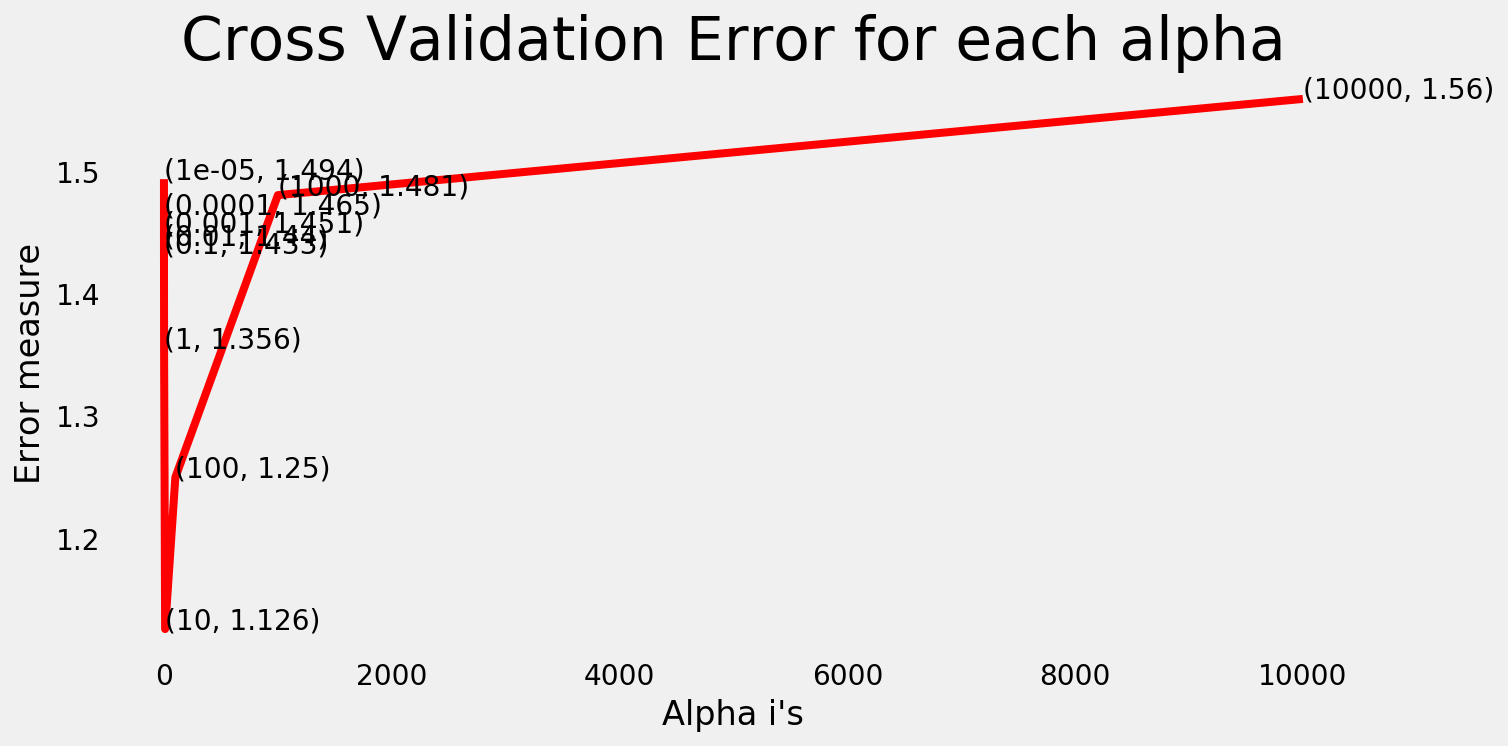

For values of best alpha =  10 The train log loss is: 0.7509093698733932
For values of best alpha =  10 The cross validation log loss is: 1.1259963098985137
For values of best alpha =  10 The test log loss is: 1.1346186844805186


In [15]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 5)]



cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(tfidf_train, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_train, y_train)
    predict_y = sig_clf.predict_proba(tfidf_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The CV log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='r')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha", fontsize = 30)
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(tfidf_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_train, y_train)

predict_y = sig_clf.predict_proba(tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


**Ok, so for alpha = 10, we get a logloss of 1.09 on the CV data and a log loss of 1.11 on the test data.**

<h1> Is this feature trustable??.. </h1>

In [16]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [17]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [18]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

69.249 % of word of test data appeared in train data
71.369 % of word of Cross Validation appeared in train data


__The TEXT feature is quite stable huh!!__

<h1>  Tfidf of gene features </h1>

In [19]:
train_df['Gene'].head()

1730     MSH2
1643     FLT3
389      TP53
962      ESR1
2441    BRCA1
Name: Gene, dtype: object

In [20]:
gene_vectorizer = TfidfVectorizer( stop_words = "english", min_df = 3, max_features = 100000) #upto 4-grams
gene_feature_train = gene_vectorizer.fit_transform(train_df['Gene'])
gene_feature_test = gene_vectorizer.transform(test_df['Gene'])
gene_feature_cv = gene_vectorizer.transform(cv_df['Gene'])

gene_feature_train = StandardScaler(with_mean = False).fit_transform(gene_feature_train)
gene_feature_test = StandardScaler(with_mean = False).fit_transform(gene_feature_test)

gene_feature_cv = StandardScaler(with_mean = False).fit_transform(gene_feature_cv)

In [21]:
gene_vectorizer.get_feature_names()[:20]

['abl1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'atm',
 'b2m',
 'bap1',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brip1',
 'btk',
 'card11',
 'carm1']

In [22]:
joblib.dump(gene_feature_train, 'tfidf_gene_train.pkl')
joblib.dump(gene_feature_test , 'tfidf_gene_test.pkl')
joblib.dump(gene_feature_cv , 'tfidf_gene_cv.pkl')

['tfidf_gene_cv.pkl']

<h1> How good is the tfidf Gene feature in predicting yi_hat??.. </h1>

For values of alpha =  1e-05 The CV log loss is: 1.7207411566184916
For values of alpha =  0.0001 The CV log loss is: 1.7179919933108136
For values of alpha =  0.001 The CV log loss is: 1.661727146071855
For values of alpha =  0.01 The CV log loss is: 1.3537098626455242
For values of alpha =  0.1 The CV log loss is: 1.3287572141157444
For values of alpha =  1 The CV log loss is: 1.334988935515632


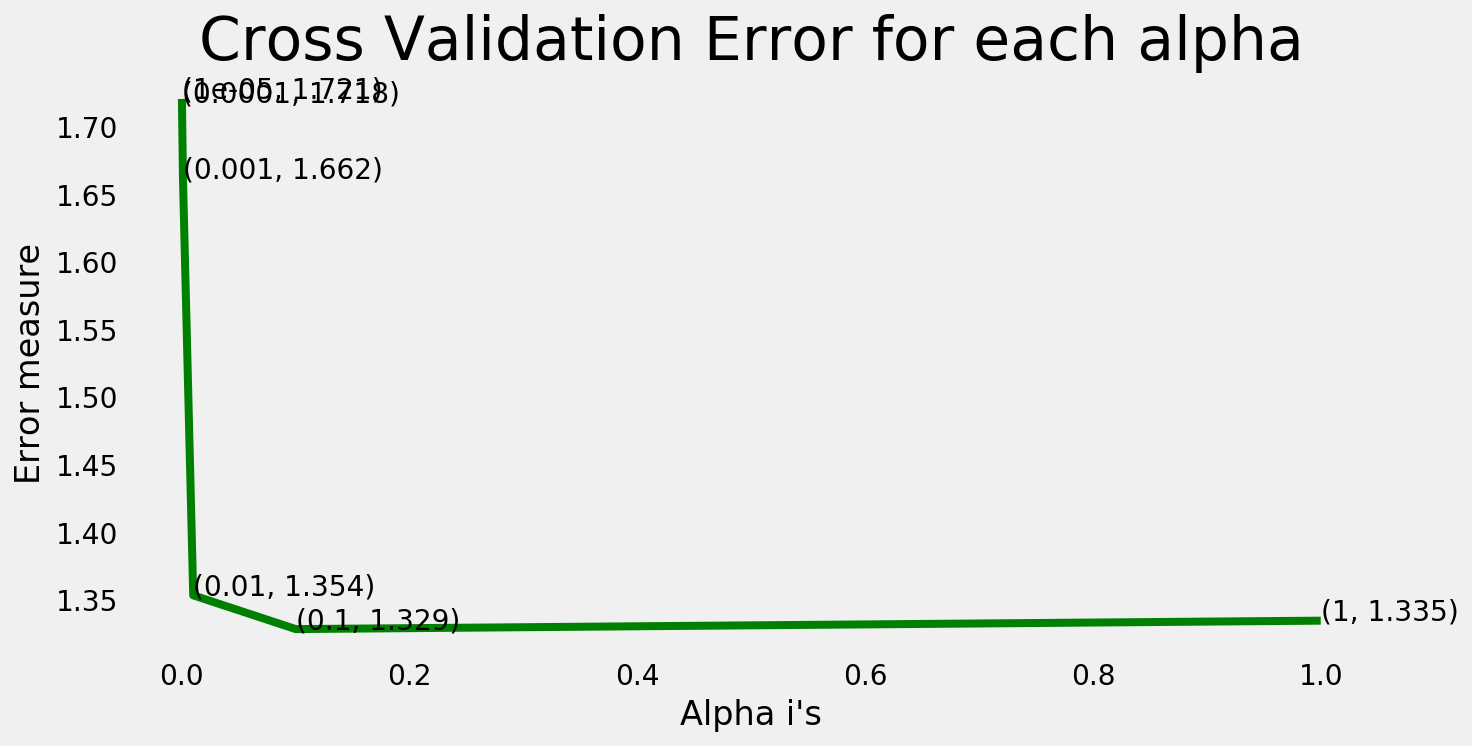

For values of best alpha =  0.1 The train log loss is: 1.1200173025322644
For values of best alpha =  0.1 The cross validation log loss is: 1.3287572141157444
For values of best alpha =  0.1 The test log loss is: 1.3109581414626894


In [23]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(gene_feature_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(gene_feature_train, y_train)
    predict_y = sig_clf.predict_proba(gene_feature_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The CV log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha", fontsize = 30)
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(gene_feature_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(gene_feature_train, y_train)

predict_y = sig_clf.predict_proba(gene_feature_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(gene_feature_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(gene_feature_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [24]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)


1. In test data 324 out of 333 : 97.2972972972973
2. In cross validation data 293 out of  299 : 97.9933110367893


__Impressive...__

<h1>  Tfidf of Variation feature </h1>

In [25]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 2429
Truncating_Mutations    75
Amplification           63
Deletion                61
Fusions                 28
G12V                     4
T58I                     3
E17K                     3
Overexpression           3
Q61R                     3
G13V                     2
Name: Variation, dtype: int64


In [26]:
# one-hot encoding of variation feature.
variation_vect = TfidfVectorizer(stop_words = "english", min_df = 3, max_features = 100000) #upto 4-grams
variation_feature_train = variation_vect.fit_transform(train_df['Variation'])
variation_feature_test = variation_vect.transform(test_df['Variation'])
variation_feature_cv = variation_vect.transform(cv_df['Variation'])


variation_feature_train = StandardScaler(with_mean = False).fit_transform(variation_feature_train)
variation_feature_test = StandardScaler(with_mean = False).fit_transform(variation_feature_test)

variation_feature_cv = StandardScaler(with_mean = False).fit_transform(variation_feature_cv)

In [27]:
joblib.dump(variation_feature_train, 'tfidf_variation_train.pkl')
joblib.dump(variation_feature_test , 'tfidf_variation_test.pkl')
joblib.dump(variation_feature_cv , 'tfidf_variation_cv.pkl')

['tfidf_variation_cv.pkl']

<h1> How good is the tfidf Variation feature in predicting yi_hat??.. </h1>

For values of alpha =  1e-05 The CV log loss is: 1.758731609936776
For values of alpha =  0.0001 The CV log loss is: 1.7584711365570387
For values of alpha =  0.001 The CV log loss is: 1.7546412287440416
For values of alpha =  0.01 The CV log loss is: 1.7489973371006406
For values of alpha =  0.1 The CV log loss is: 1.75688180960837
For values of alpha =  1 The CV log loss is: 1.7594987065106322


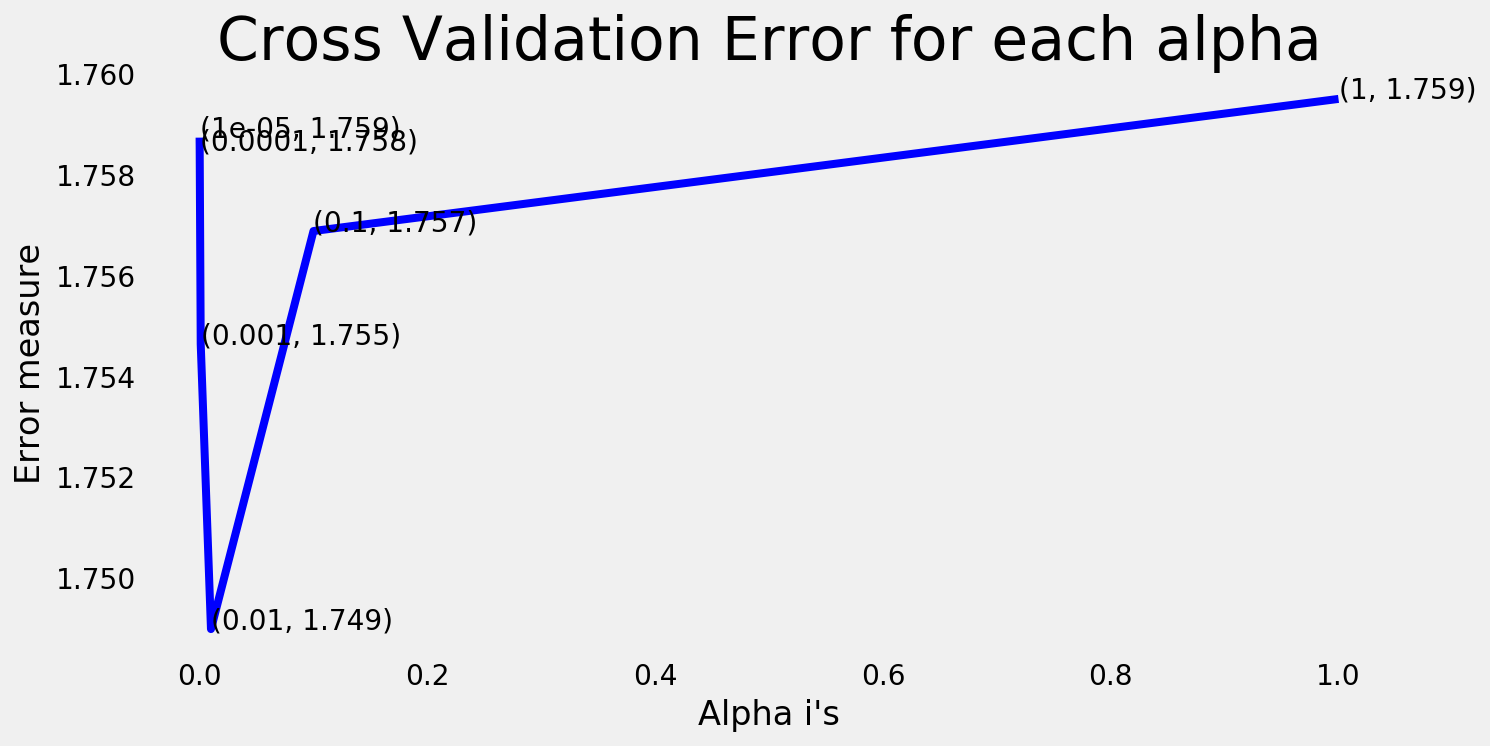

For values of best alpha =  0.01 The train log loss is: 1.6960941958118347
For values of best alpha =  0.01 The cross validation log loss is: 1.7489973371006406
For values of best alpha =  0.01 The test log loss is: 1.6869605145320423


In [28]:
alpha = [10 ** x for x in range(-5, 1)]



cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(variation_feature_train, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(variation_feature_train, y_train)
    predict_y = sig_clf.predict_proba(variation_feature_cv)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The CV log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='b')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha", fontsize = 30)
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(variation_feature_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(variation_feature_train, y_train)

predict_y = sig_clf.predict_proba(variation_feature_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(variation_feature_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(variation_feature_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [29]:
print("How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

How many data points are covered by total  2429  genes in test and cross validation data sets?

1. In test data 42 out of 333 : 12.612612612612612
2. In cross validation data 22 out of  299 : 7.357859531772576


**ehhh.... Not good enough**

In [30]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var = hstack((gene_feature_train,variation_feature_train))
test_gene_var = hstack((gene_feature_test,variation_feature_test))
cv_gene_var = hstack((gene_feature_cv,variation_feature_cv))

train_x = hstack((train_gene_var, tfidf_train)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x = hstack((test_gene_var, tfidf_test)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x = hstack((cv_gene_var, tfidf_cv)).tocsr()
cv_y = np.array(list(cv_df['Class']))




In [31]:
new_df = [train_gene_var,test_gene_var,cv_gene_var,train_x,train_y,test_x,test_y,cv_x,cv_y, data['Class']]
df = pd.DataFrame([new_df],columns=['train_gene_var','test_gene_var',
                                'cv_gene_var','train_x','train_y',
                                'test_x','test_y','cv_x','cv_y', 'Class'])

In [32]:
df.to_csv('features_made.csv', index=True)

In [33]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)
    
    
    
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

# Naive Bayes:

for alpha = 1e-05
Log Loss : 1.3563552528767389
for alpha = 0.0001
Log Loss : 1.3685151000108524
for alpha = 0.001
Log Loss : 1.3789442181306009
for alpha = 0.1
Log Loss : 1.3964820358723655
for alpha = 1
Log Loss : 1.4258927461805755
for alpha = 10
Log Loss : 1.4717204261027304
for alpha = 100
Log Loss : 1.5198142100178327
for alpha = 1000
Log Loss : 1.5659841987476792


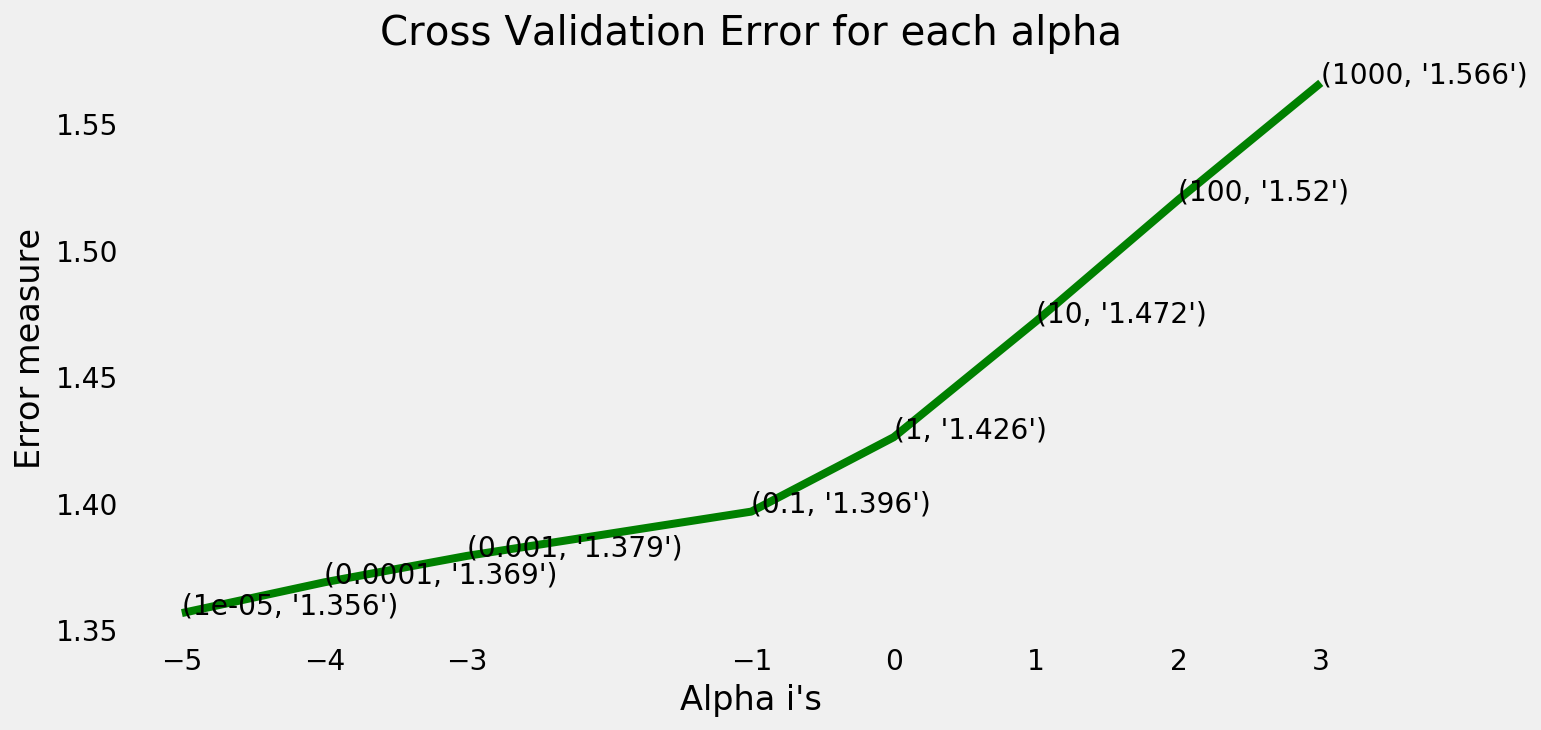

For values of best alpha =  1e-05 The train log loss is: 1.0671093073114115
For values of best alpha =  1e-05 The cross validation log loss is: 1.3563552528767389
For values of best alpha =  1e-05 The test log loss is: 1.365111070990519


In [34]:




alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)


predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.3563552528767389
Number of missclassified point : 0.41471571906354515
-------------------- Confusion matrix --------------------


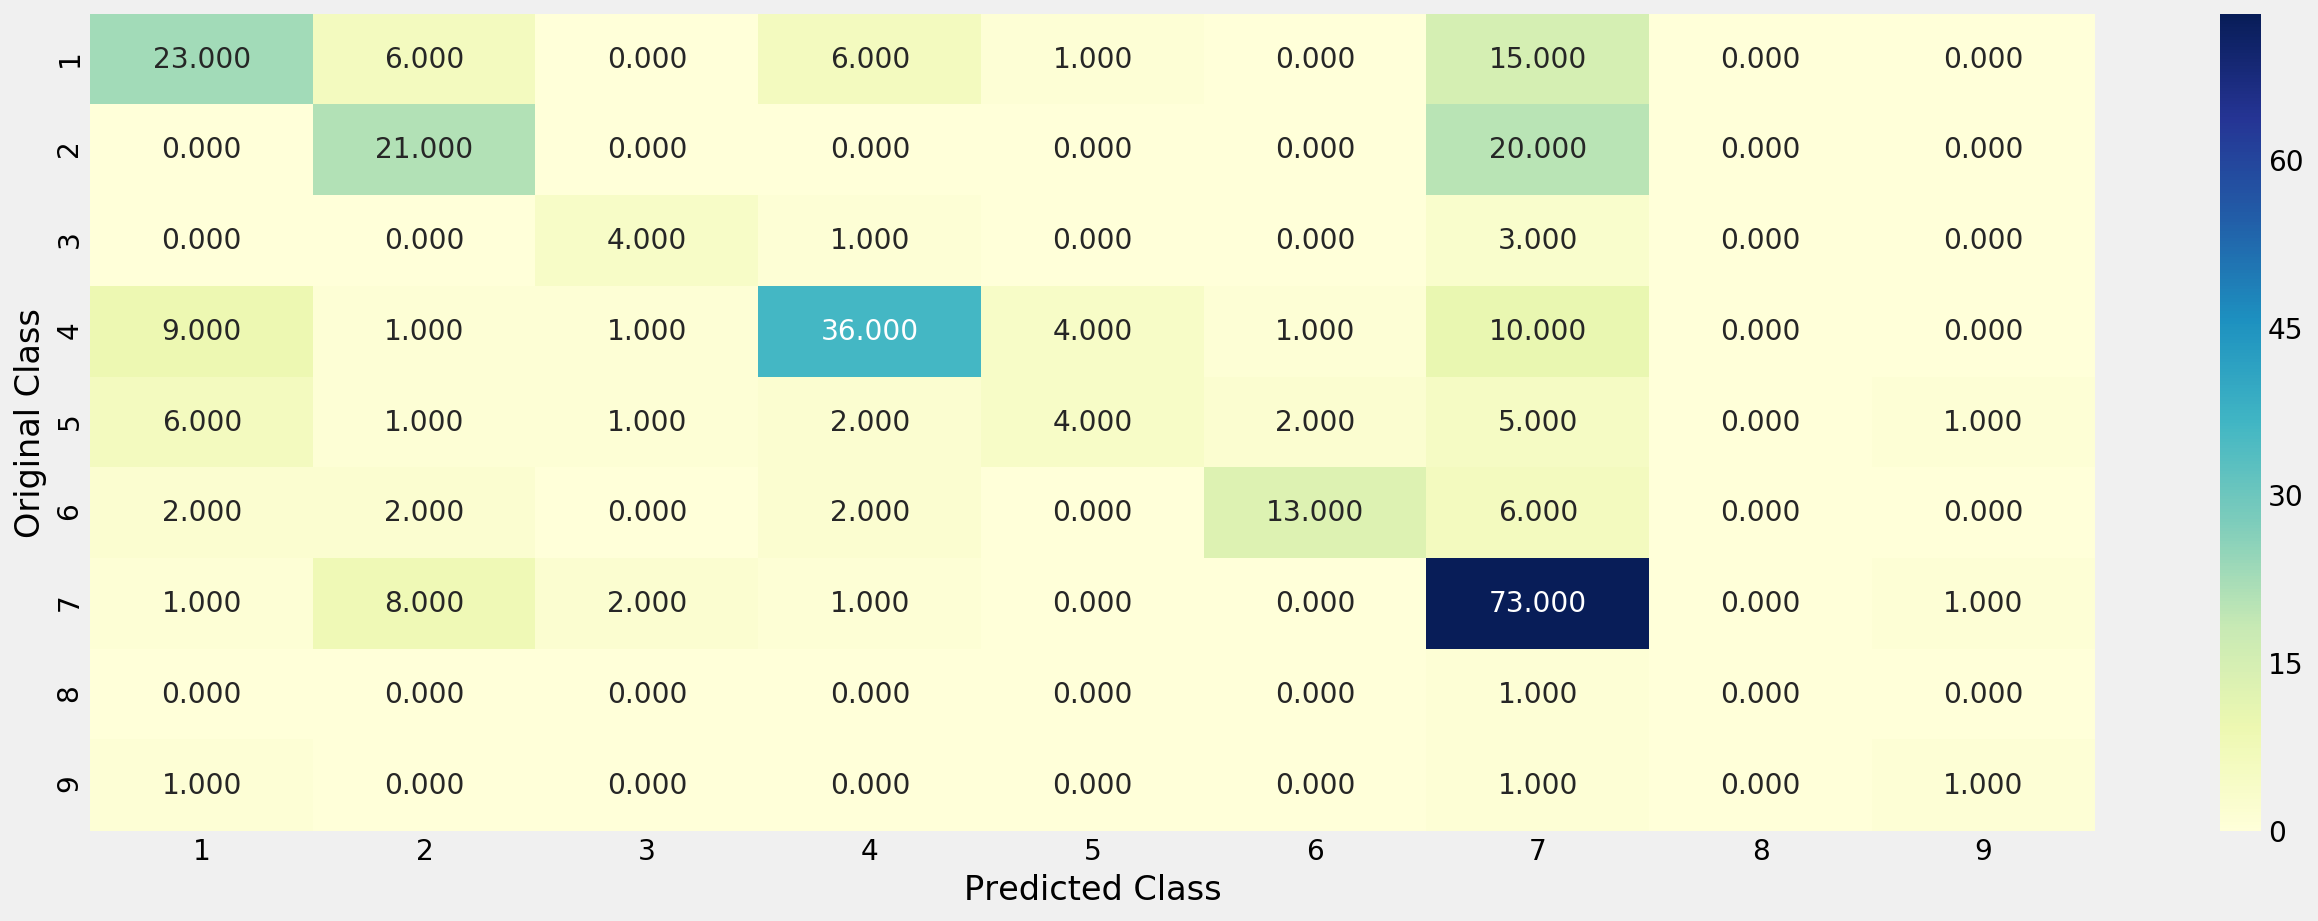

-------------------- Precision matrix (Columm Sum=1) --------------------


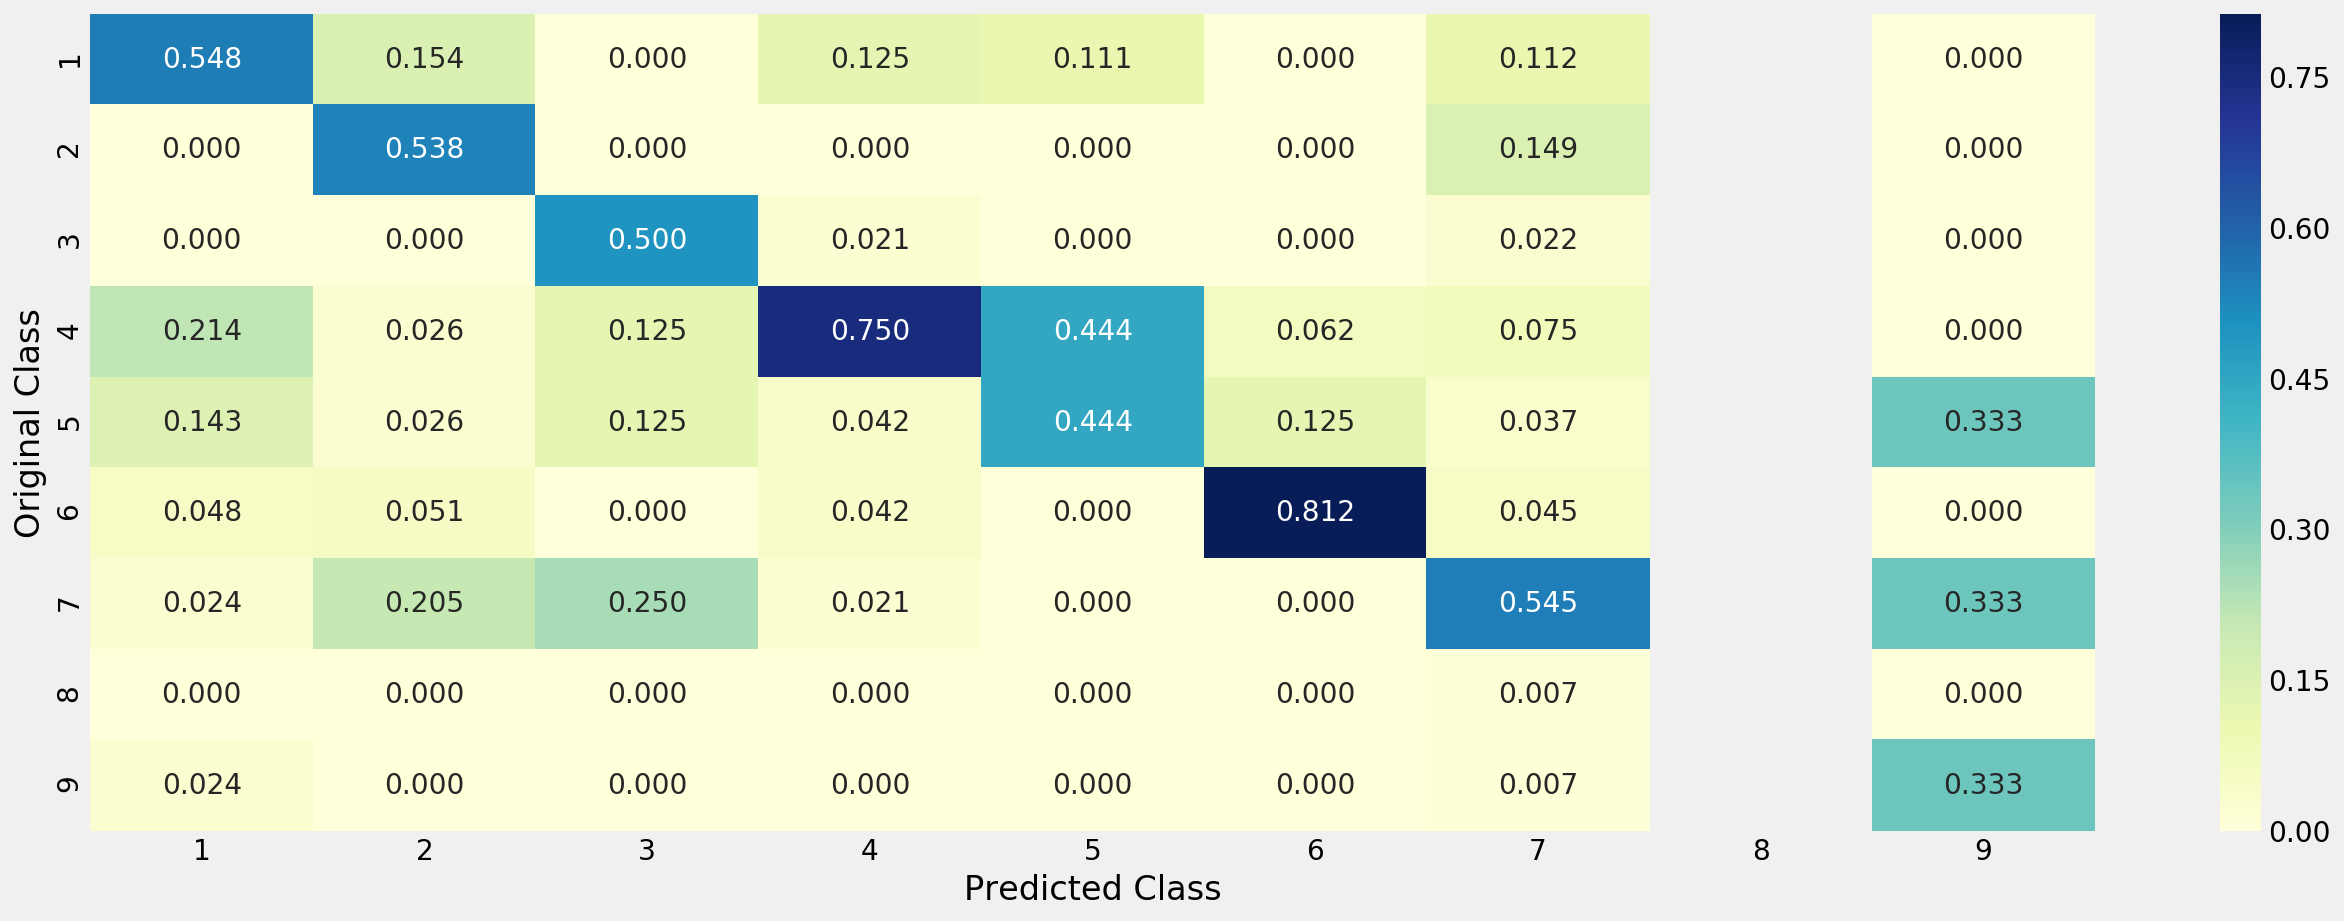

-------------------- Recall matrix (Row sum=1) --------------------


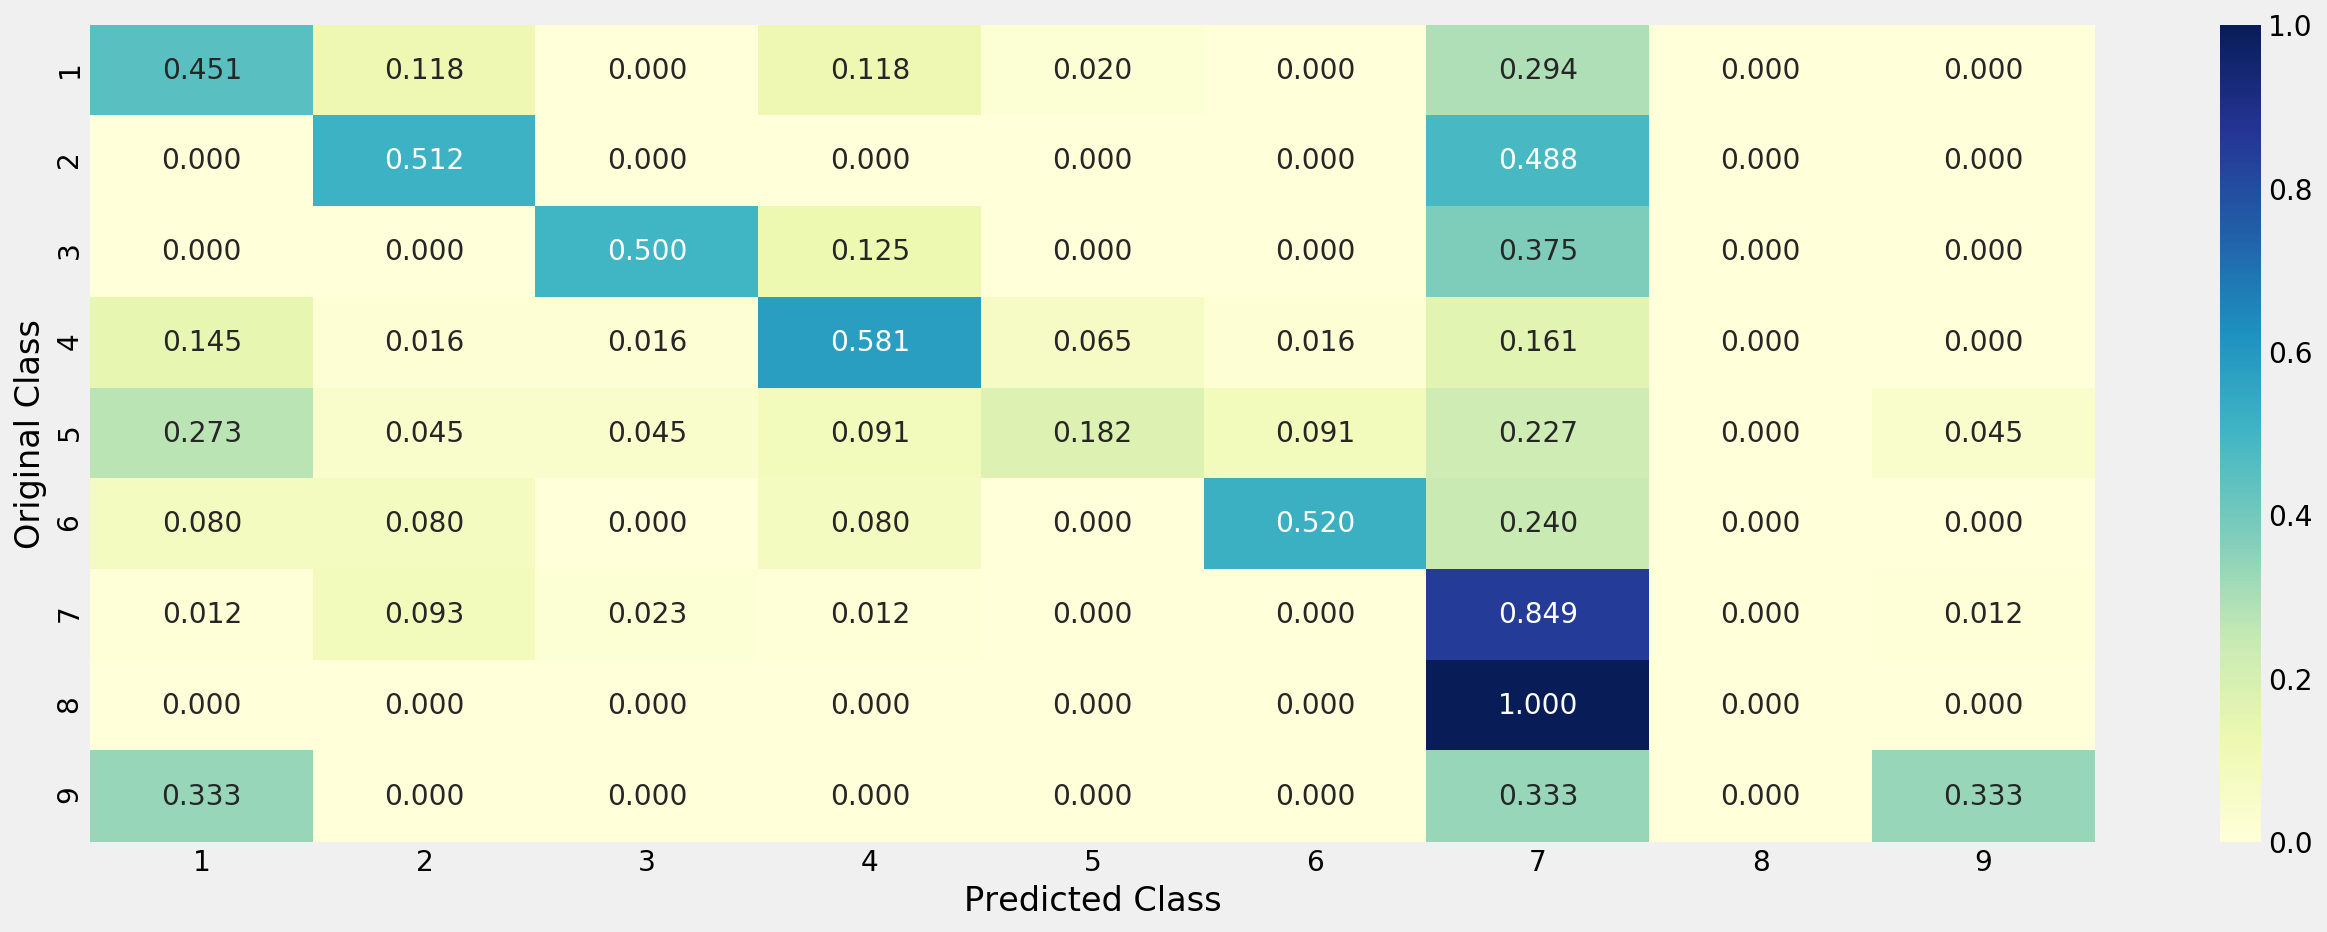

In [35]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x.toarray()))

for alpha = 1e-06
Log Loss : 1.8217901844402558
for alpha = 1e-05
Log Loss : 1.5962428518180747
for alpha = 0.0001
Log Loss : 1.5021766886601433
for alpha = 0.001
Log Loss : 1.4822363300103956
for alpha = 0.01
Log Loss : 1.5207993976623018
for alpha = 0.1
Log Loss : 1.4842498016384233
for alpha = 1
Log Loss : 1.3483040897063612
for alpha = 10
Log Loss : 1.1402553103025466
for alpha = 100
Log Loss : 1.2906110391093621


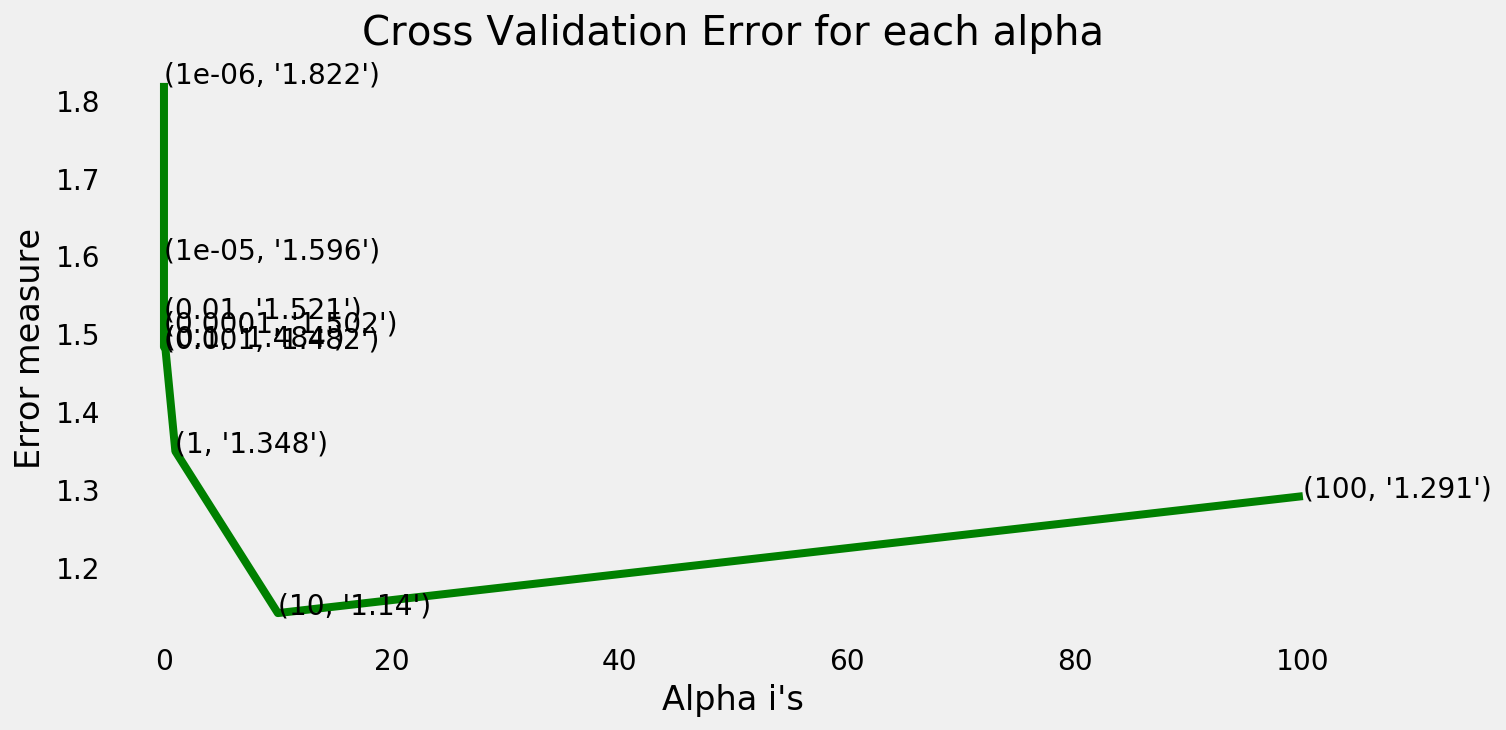

For values of best alpha =  10 The train log loss is: 0.7660945018827932
For values of best alpha =  10 The cross validation log loss is: 1.1402553103025466
For values of best alpha =  10 The test log loss is: 1.1395481374371412


In [36]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1402553103025466
Number of mis-classified points : 0.3712374581939799
-------------------- Confusion matrix --------------------


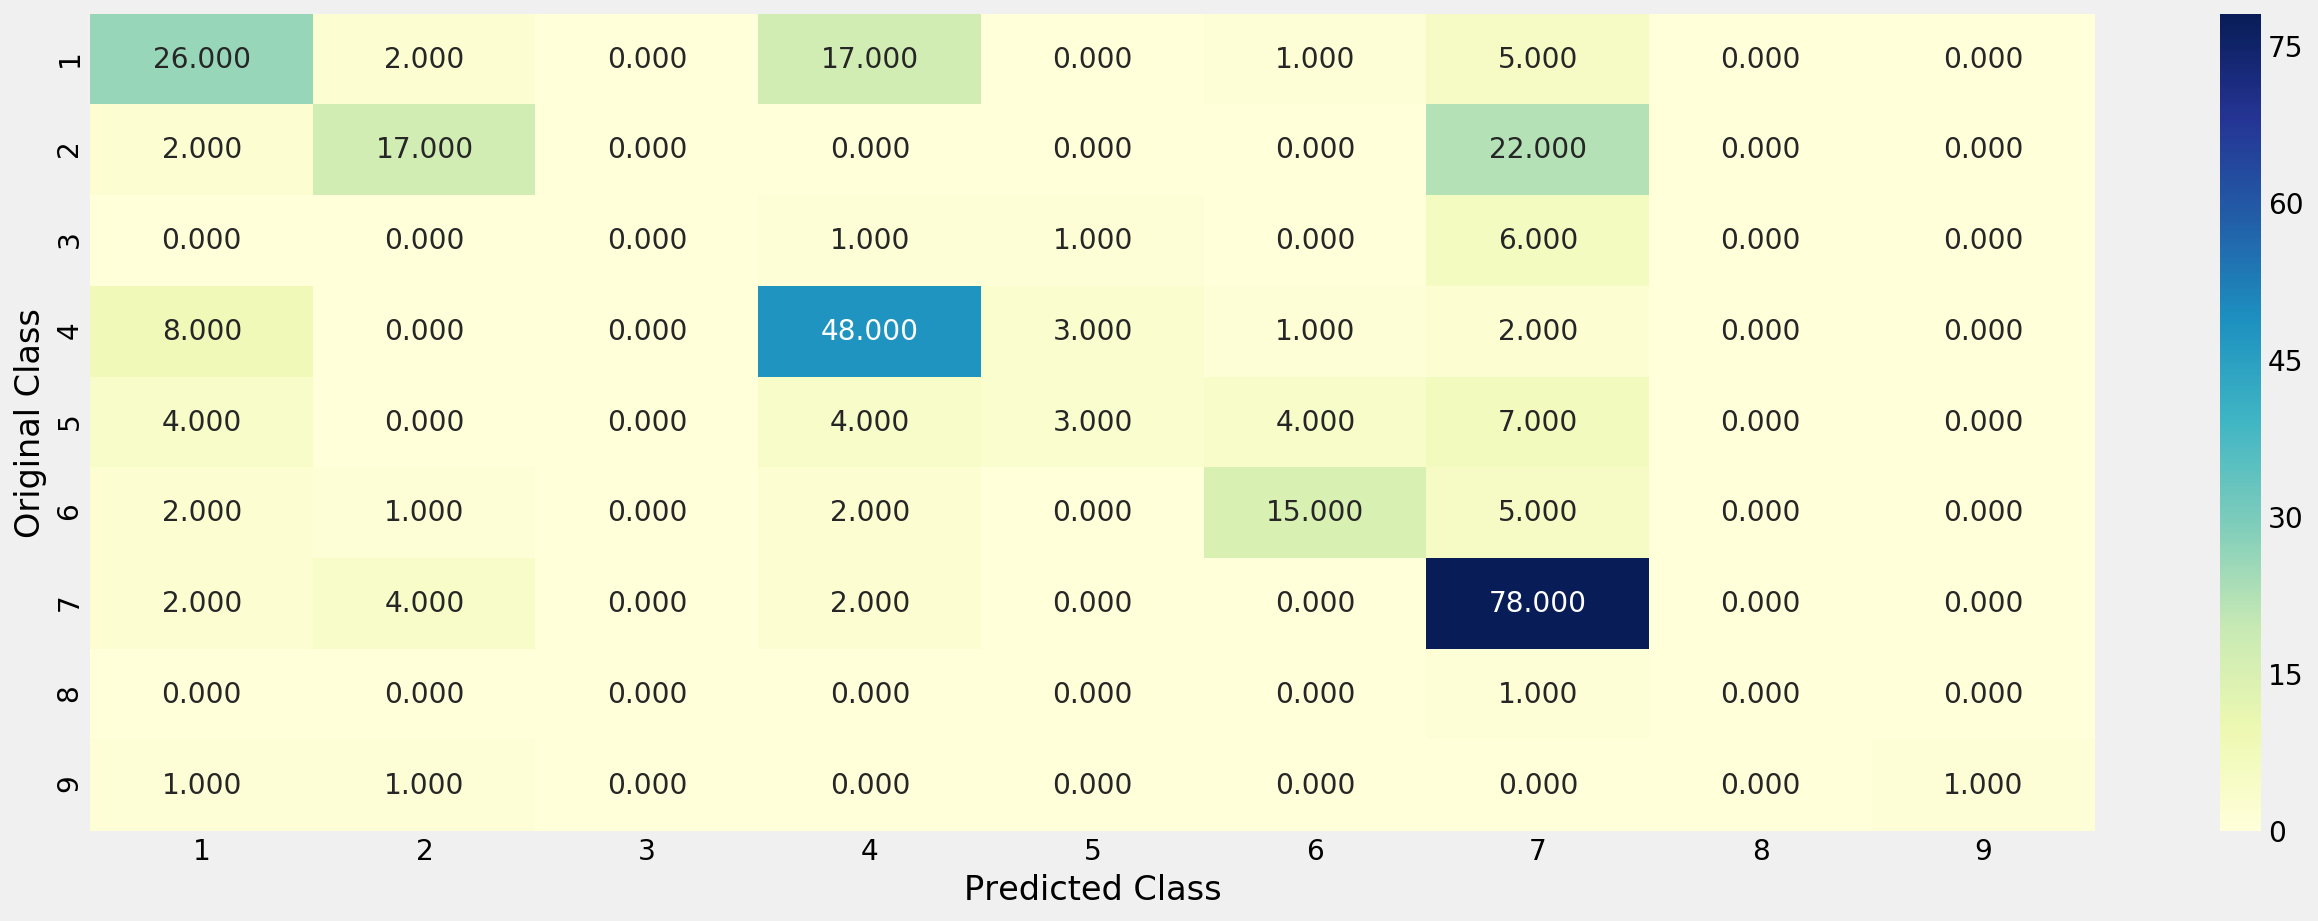

-------------------- Precision matrix (Columm Sum=1) --------------------


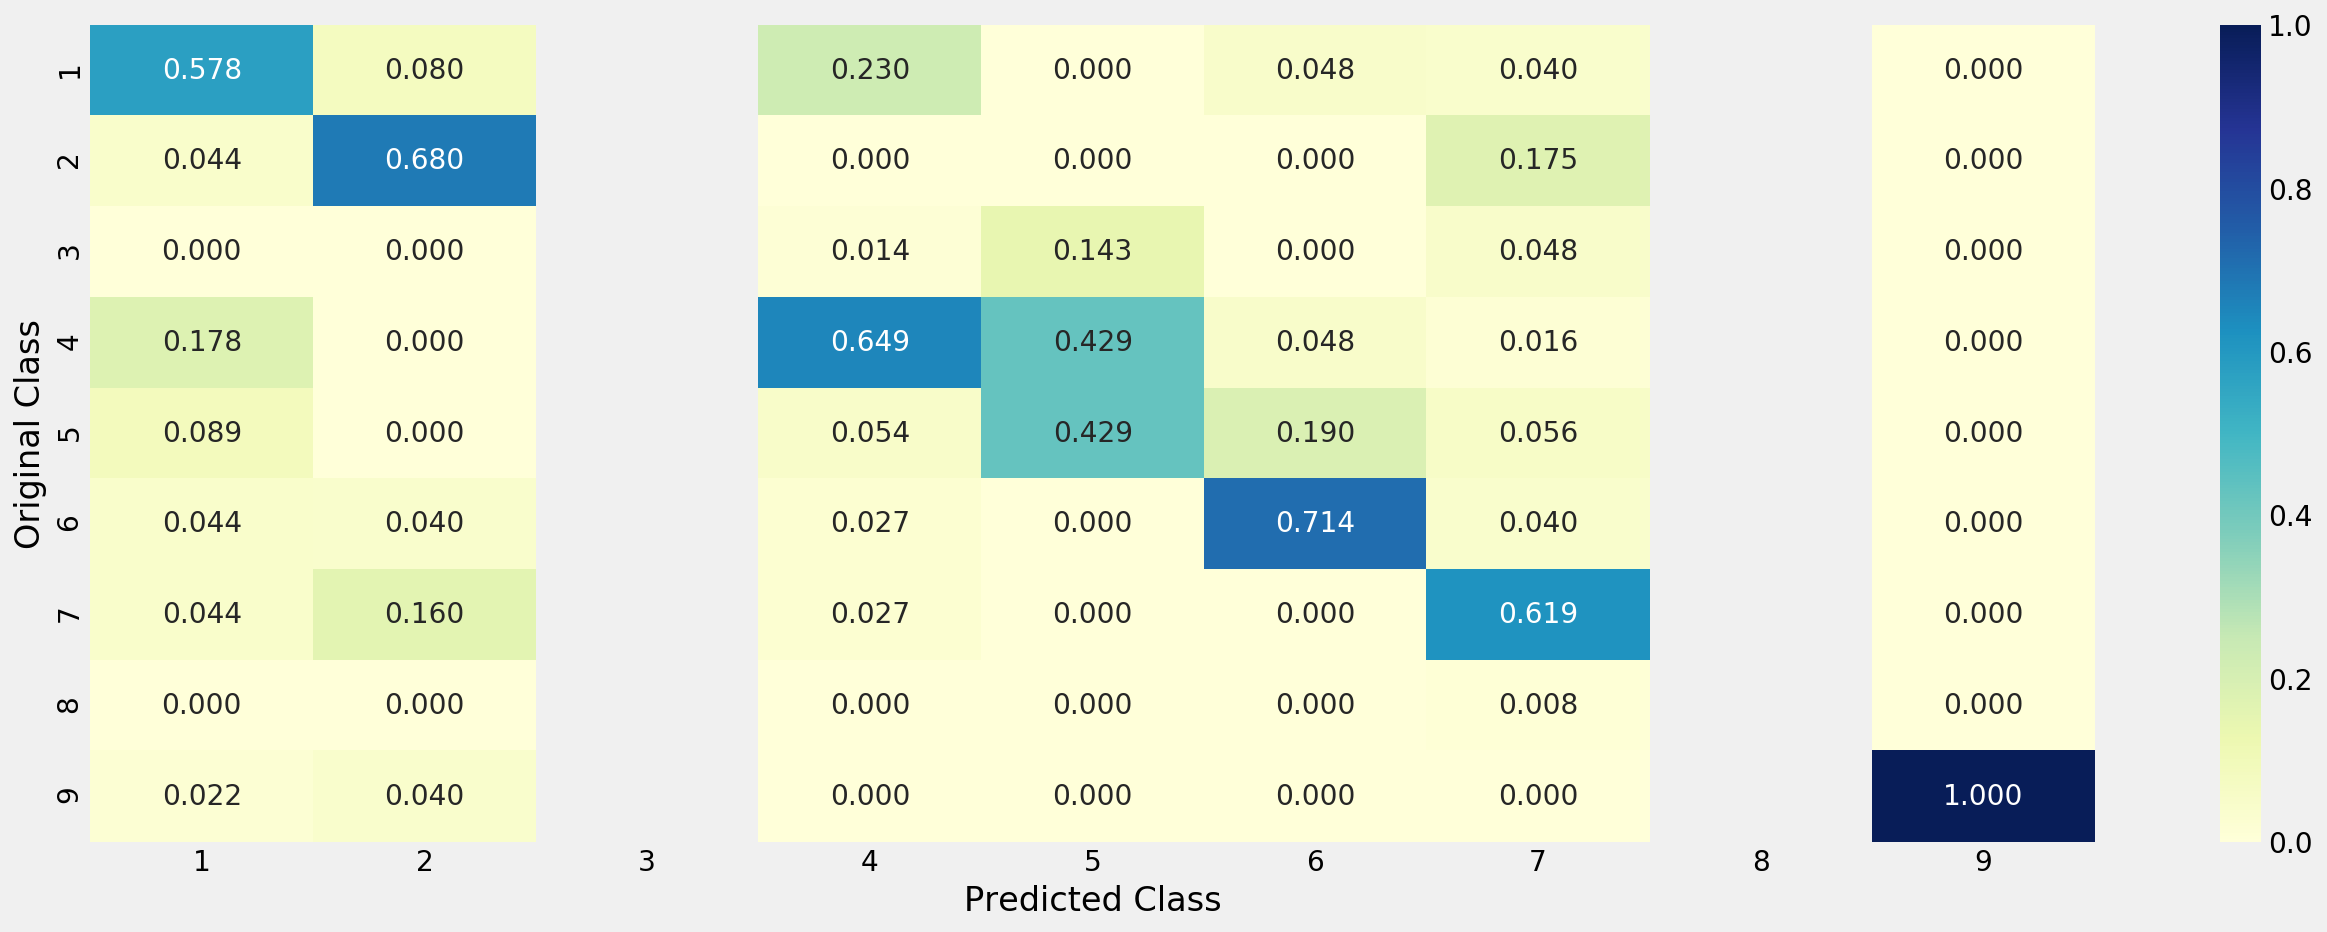

-------------------- Recall matrix (Row sum=1) --------------------


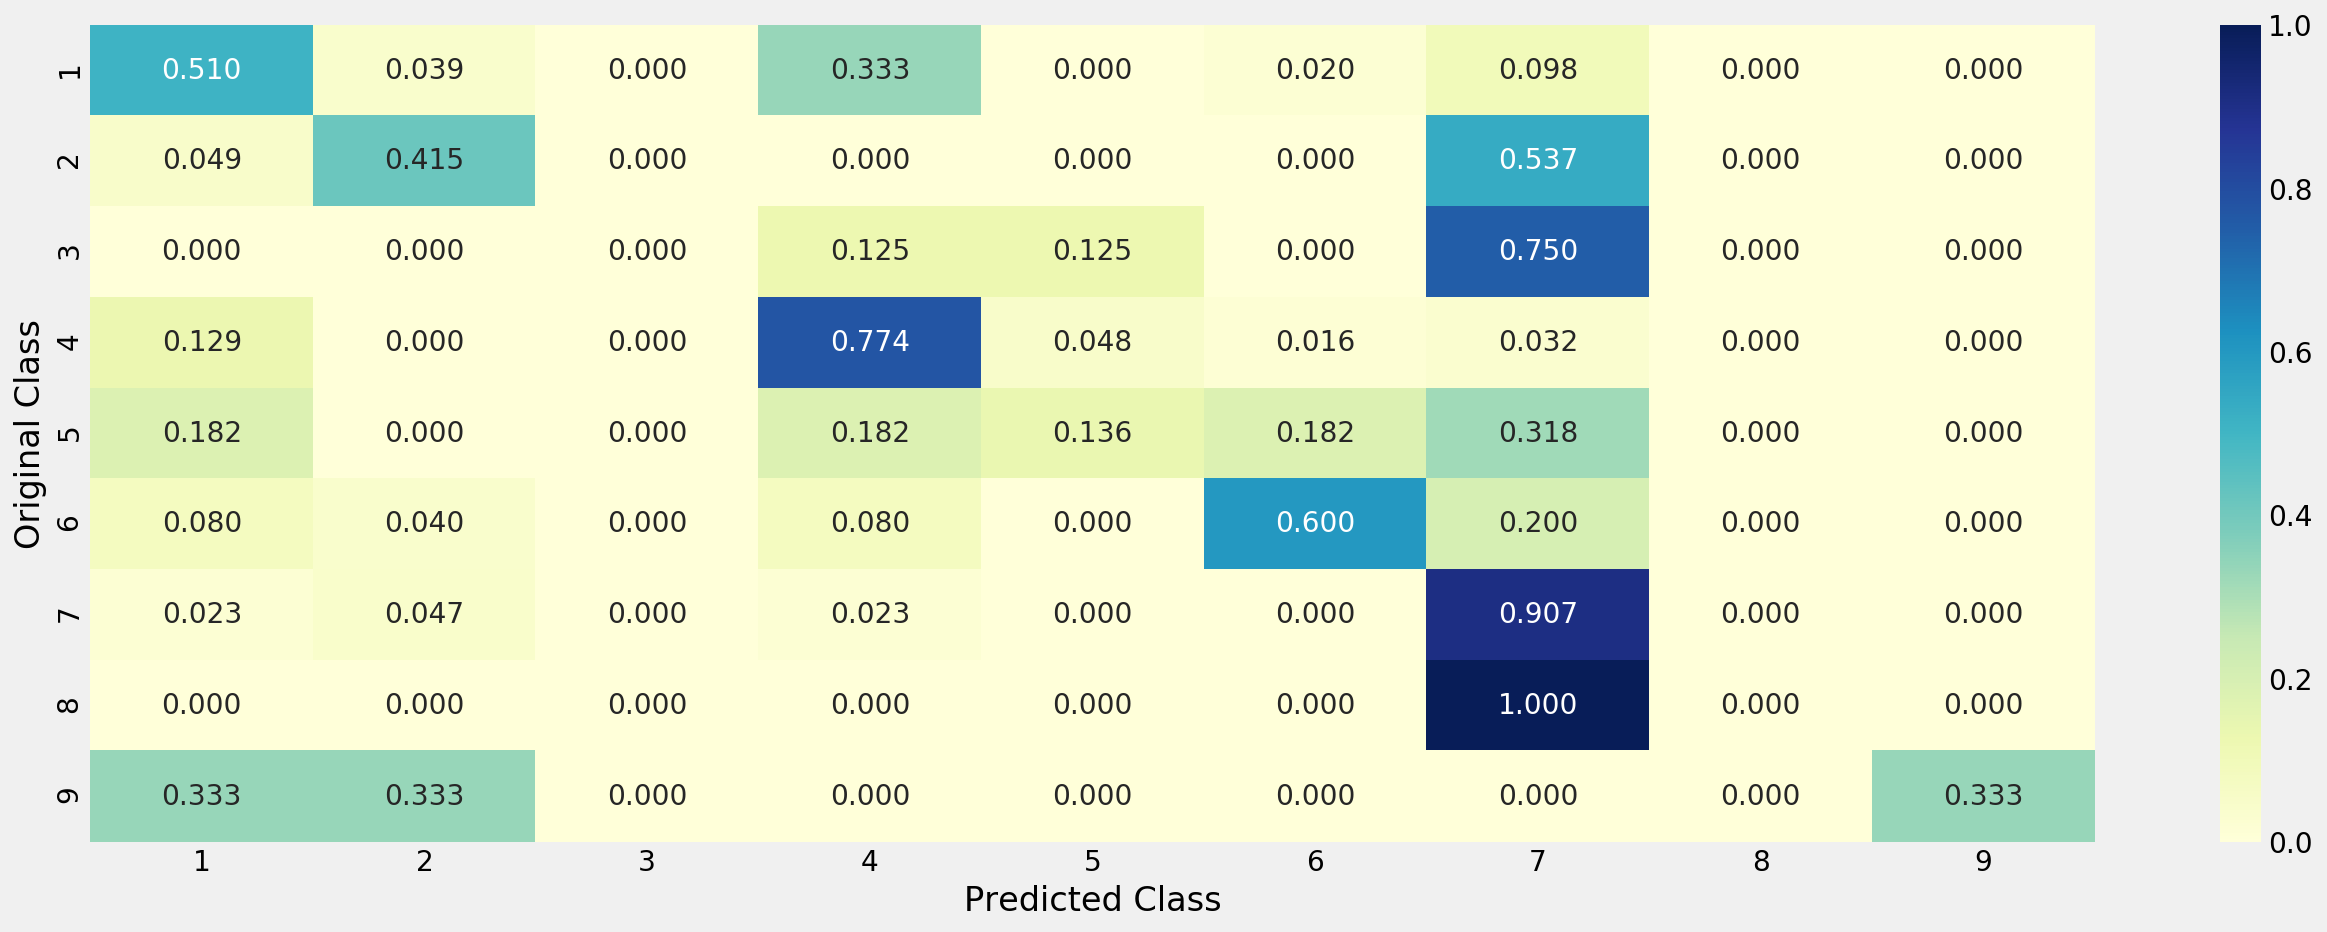

In [37]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x, train_y, cv_x, cv_y, clf)

In [46]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v+(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [47]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

__without Class Balancing__

for alpha = 1e-06
Log Loss : 1.8077519127388637
for alpha = 1e-05
Log Loss : 1.5305464863675893
for alpha = 0.0001
Log Loss : 1.452409226841552
for alpha = 0.001
Log Loss : 1.4462102226143665
for alpha = 0.01
Log Loss : 1.445001045071532
for alpha = 0.1
Log Loss : 1.4464290797615327
for alpha = 1
Log Loss : 1.3443723928690283


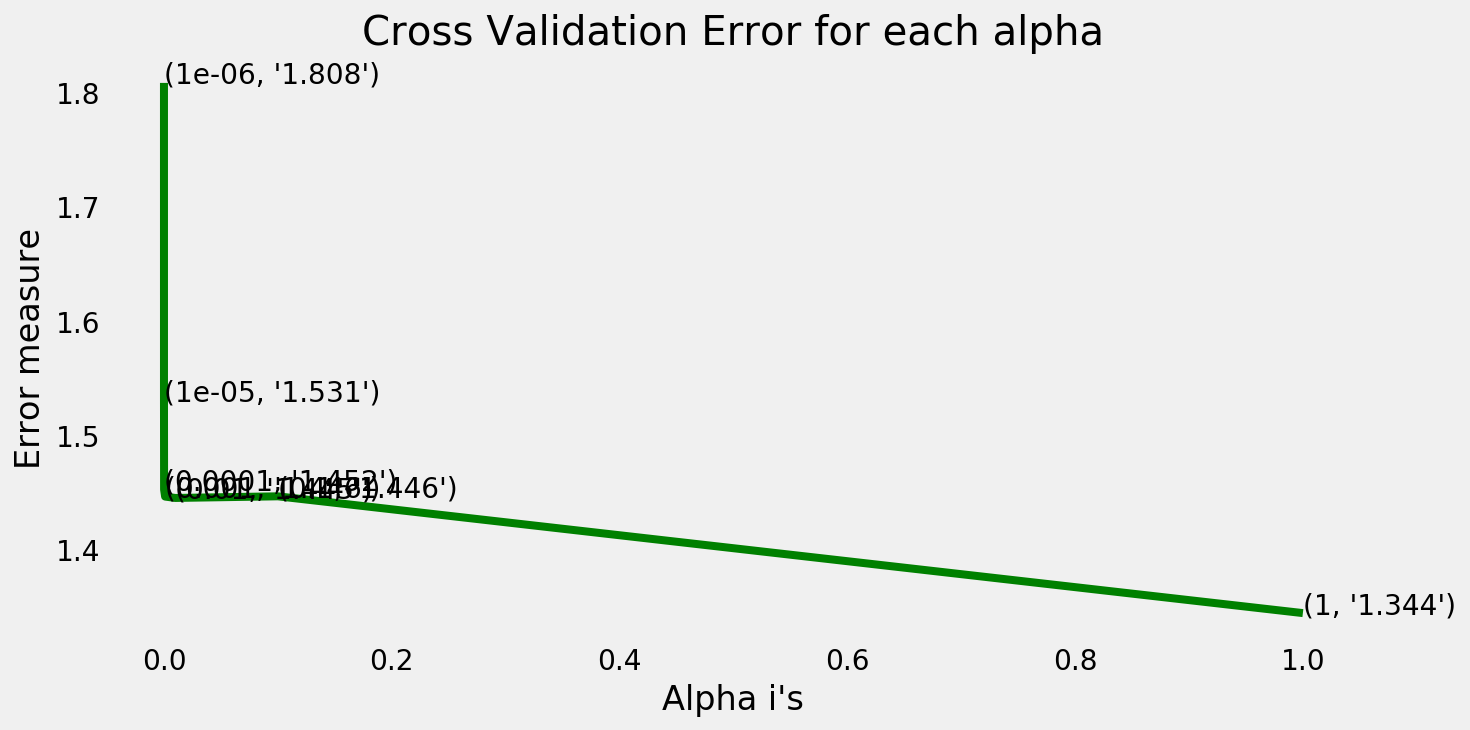

For values of best alpha =  1 The train log loss is: 1.0570610536758773
For values of best alpha =  1 The cross validation log loss is: 1.3443723928690283
For values of best alpha =  1 The test log loss is: 1.354381117103271


In [49]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.3443723928690283
Number of mis-classified points : 0.3745819397993311
-------------------- Confusion matrix --------------------


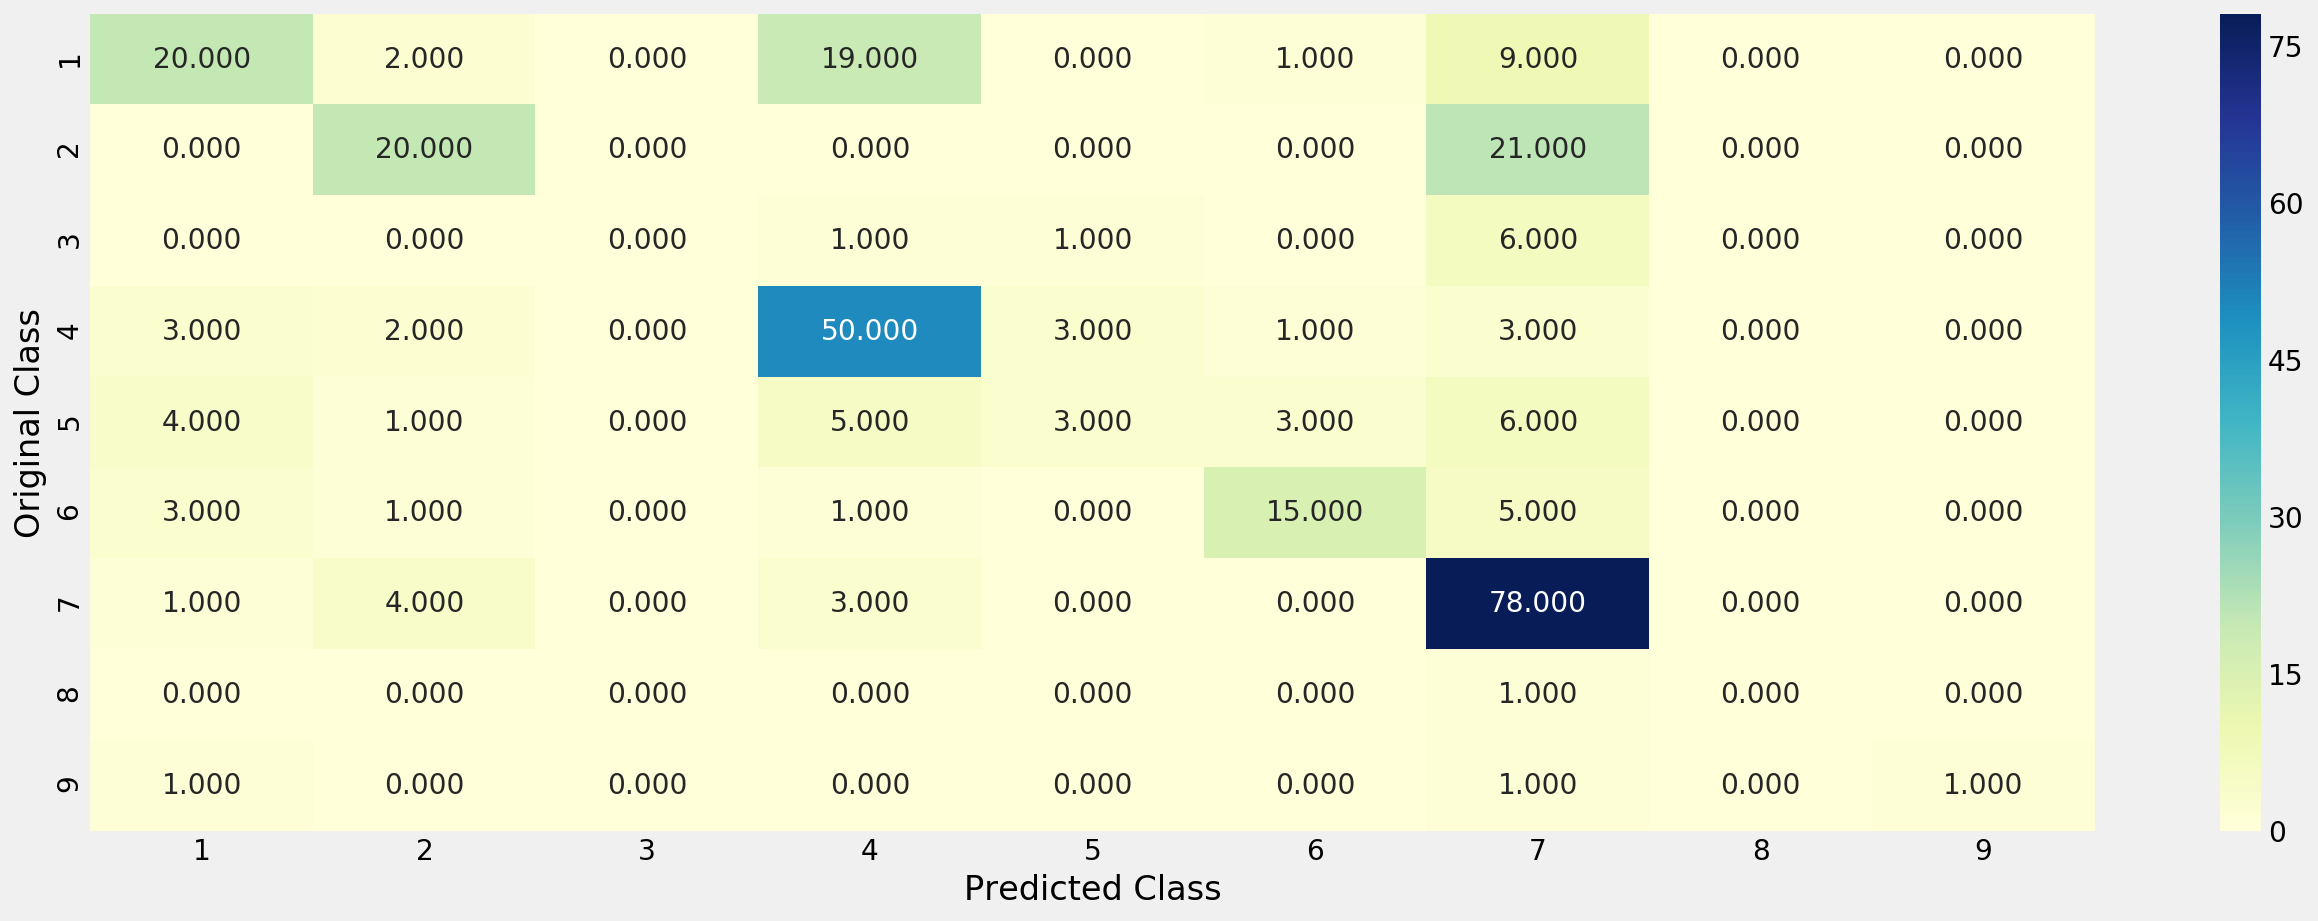

-------------------- Precision matrix (Columm Sum=1) --------------------


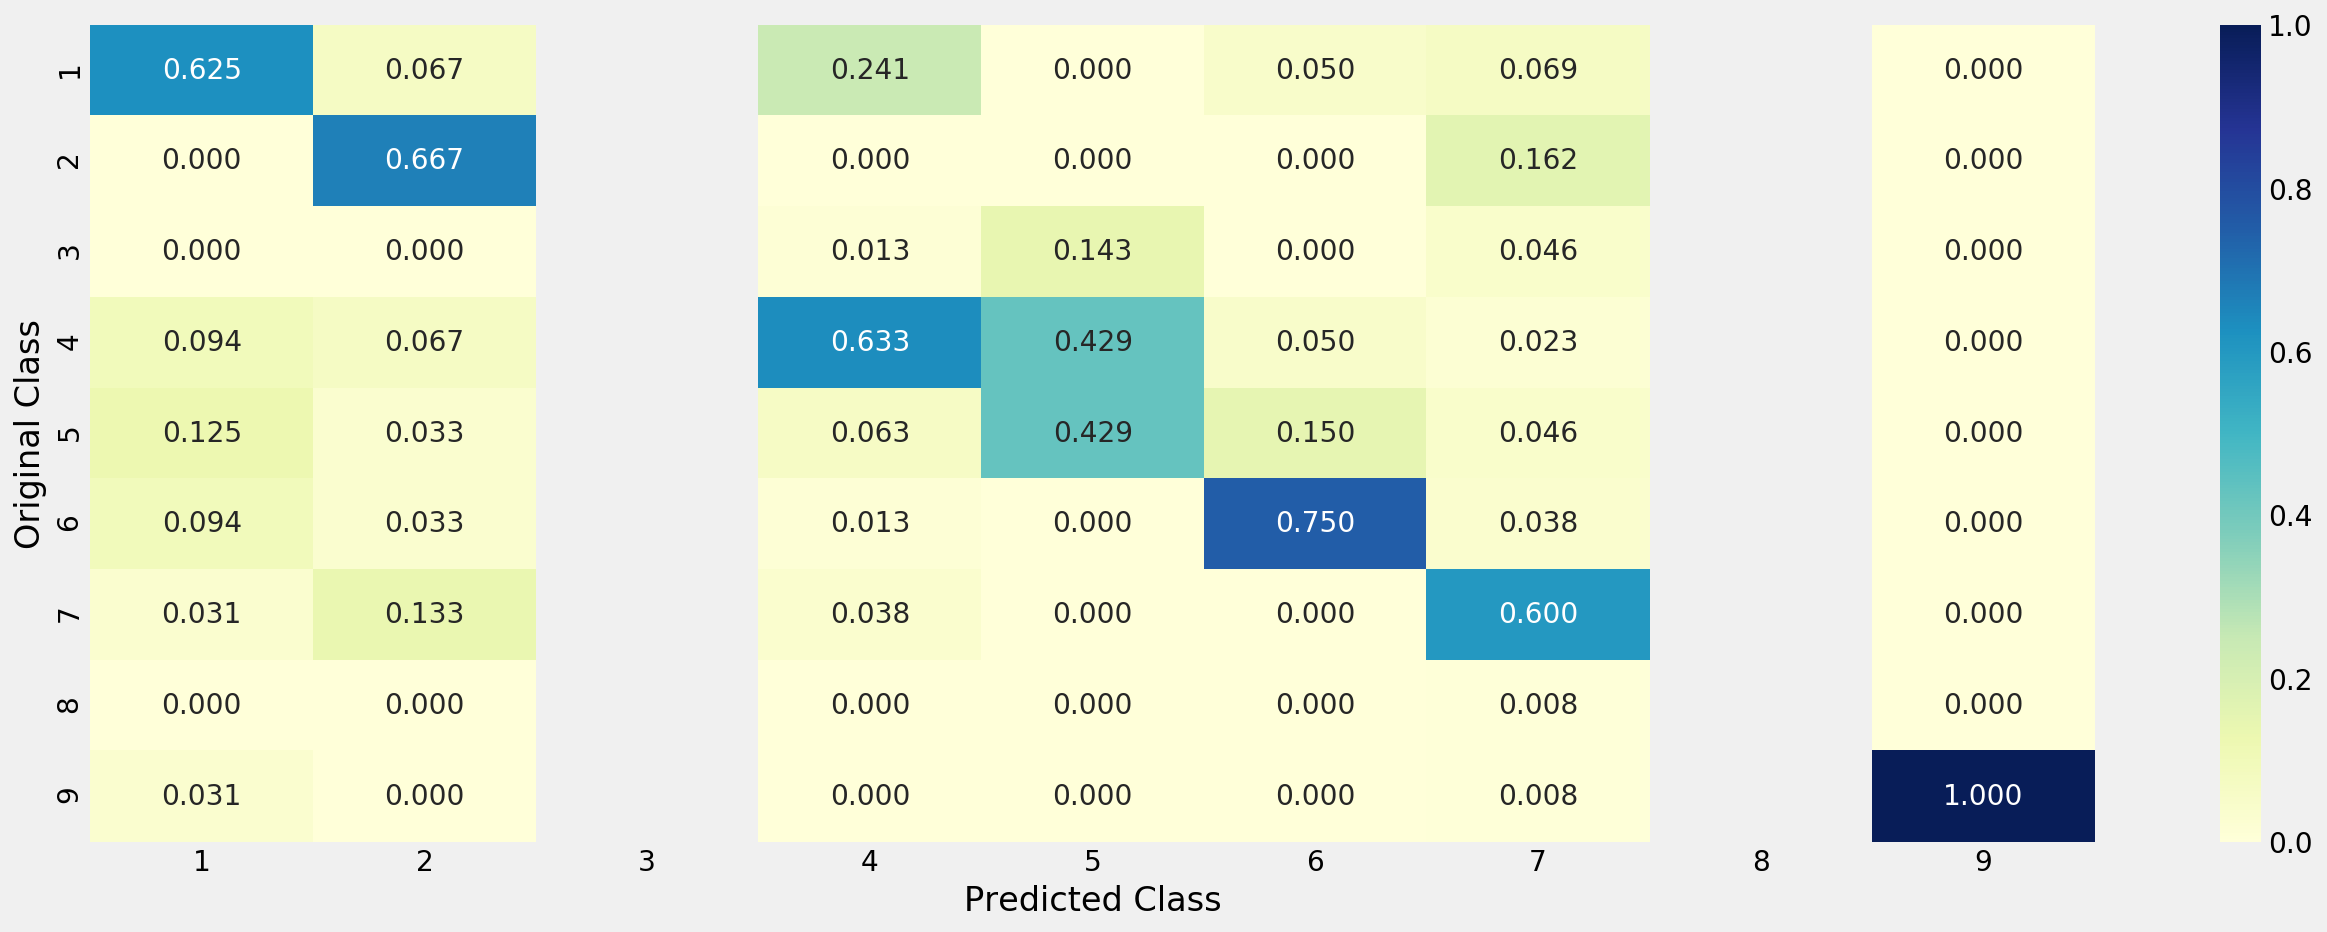

-------------------- Recall matrix (Row sum=1) --------------------


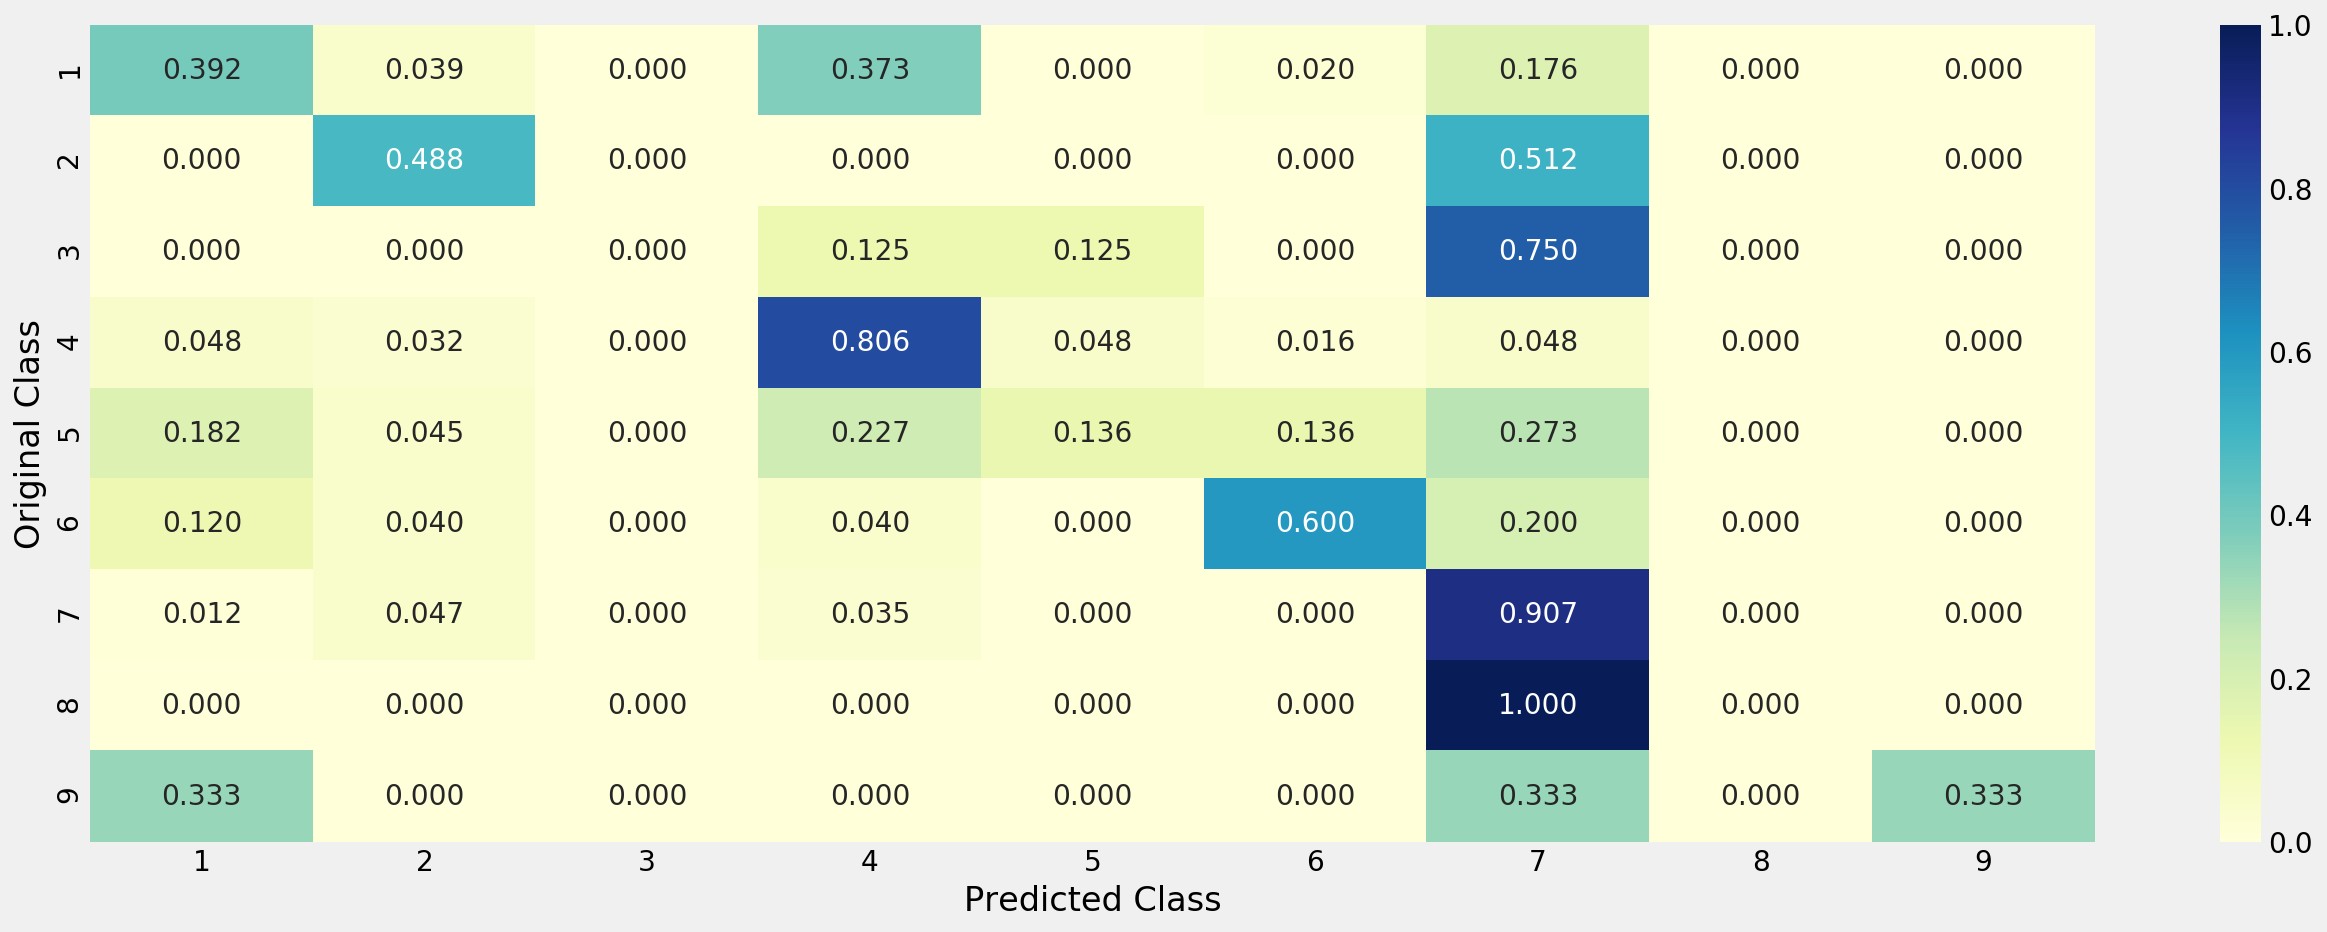

In [51]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x, train_y, cv_x, cv_y, clf)

<h2> Logistic Regression </h2>

for C = 1e-05
Log Loss : 1.605905534418298
for C = 0.0001
Log Loss : 1.5087505474659366
for C = 0.001
Log Loss : 1.497220167439556
for C = 0.01
Log Loss : 1.4846798969127228
for C = 0.1
Log Loss : 1.5061356075460937
for C = 1
Log Loss : 1.4333943398378537
for C = 10
Log Loss : 1.2837031192365076
for C = 100
Log Loss : 1.321232231565631


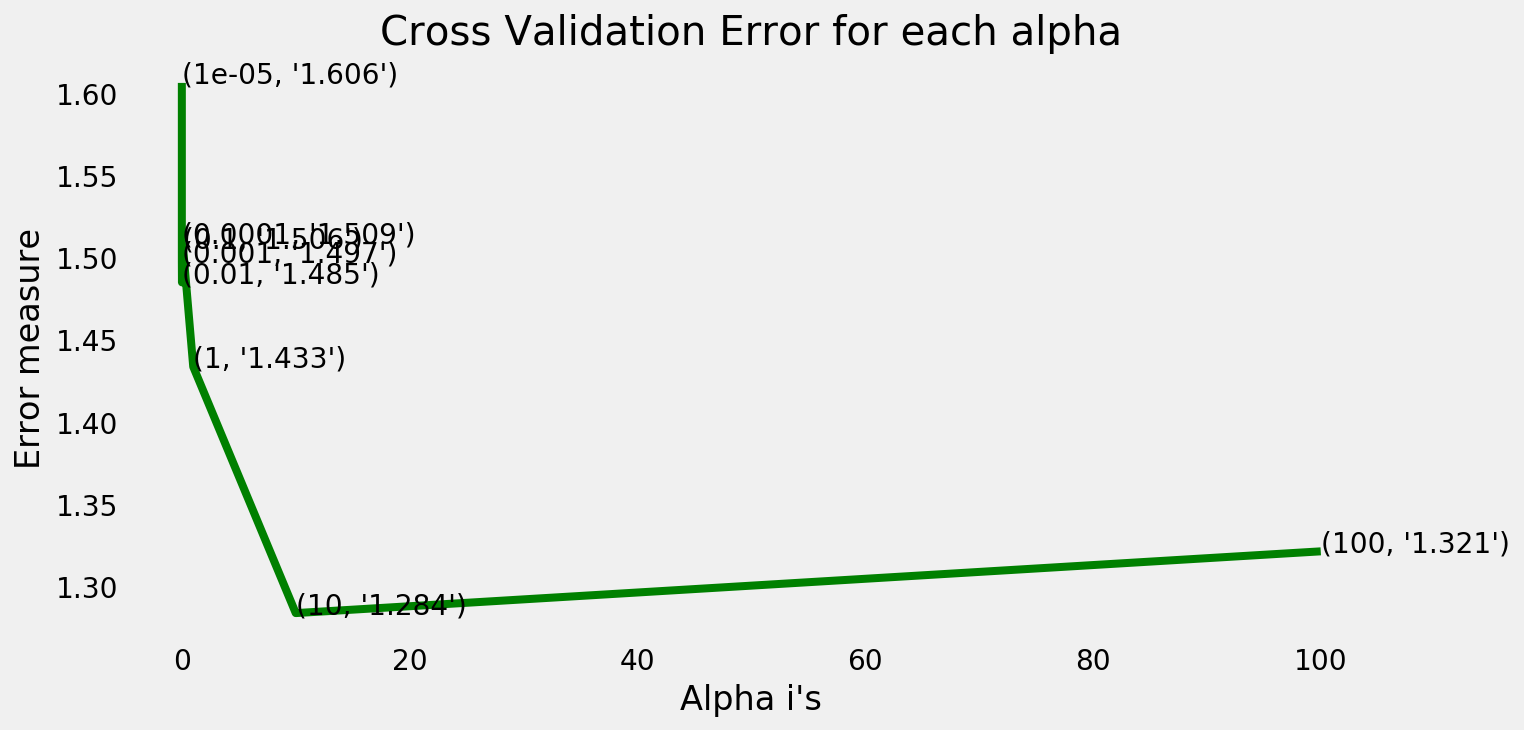

For values of best alpha =  10 The train log loss is: 0.8818178372947316
For values of best alpha =  10 The cross validation log loss is: 1.2837031192365076
For values of best alpha =  10 The test log loss is: 1.2674747737903003


In [52]:

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.2837031192365076
Number of mis-classified points : 0.36789297658862874
-------------------- Confusion matrix --------------------


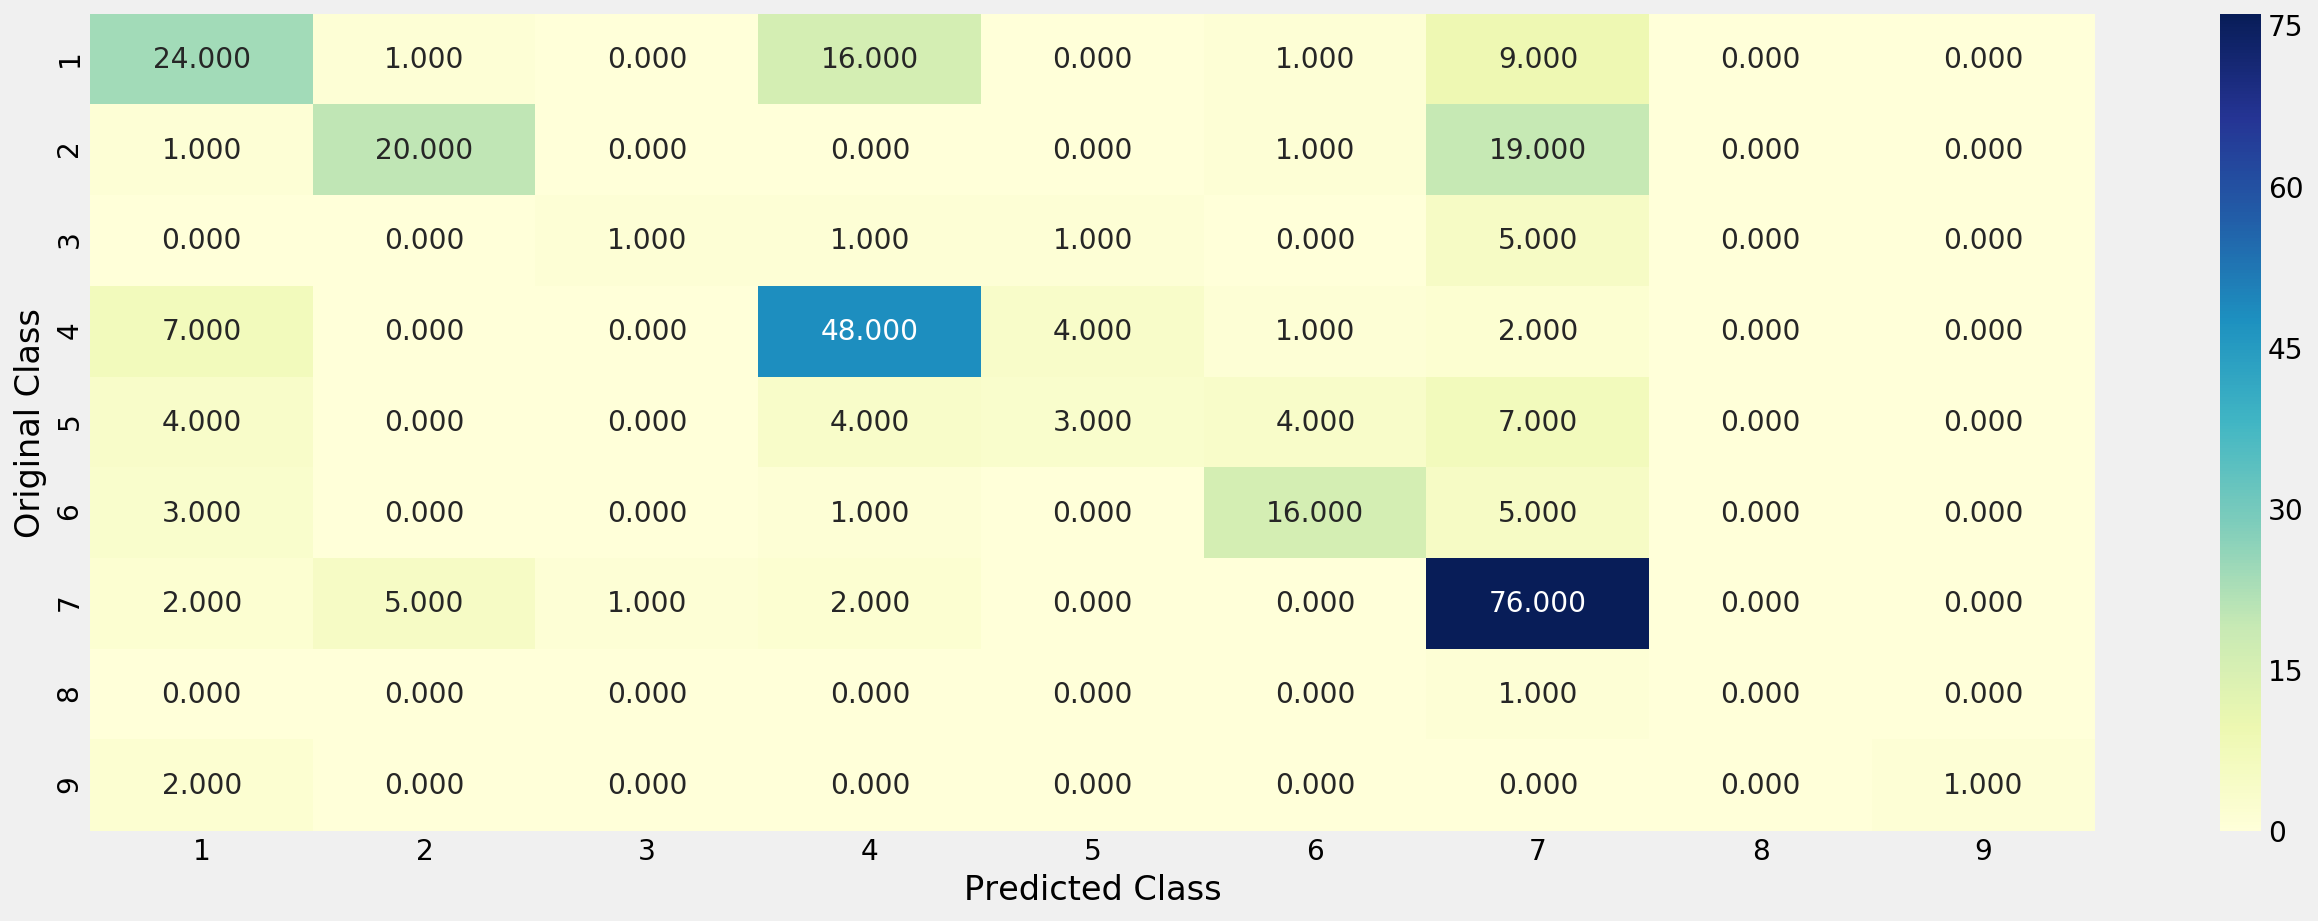

-------------------- Precision matrix (Columm Sum=1) --------------------


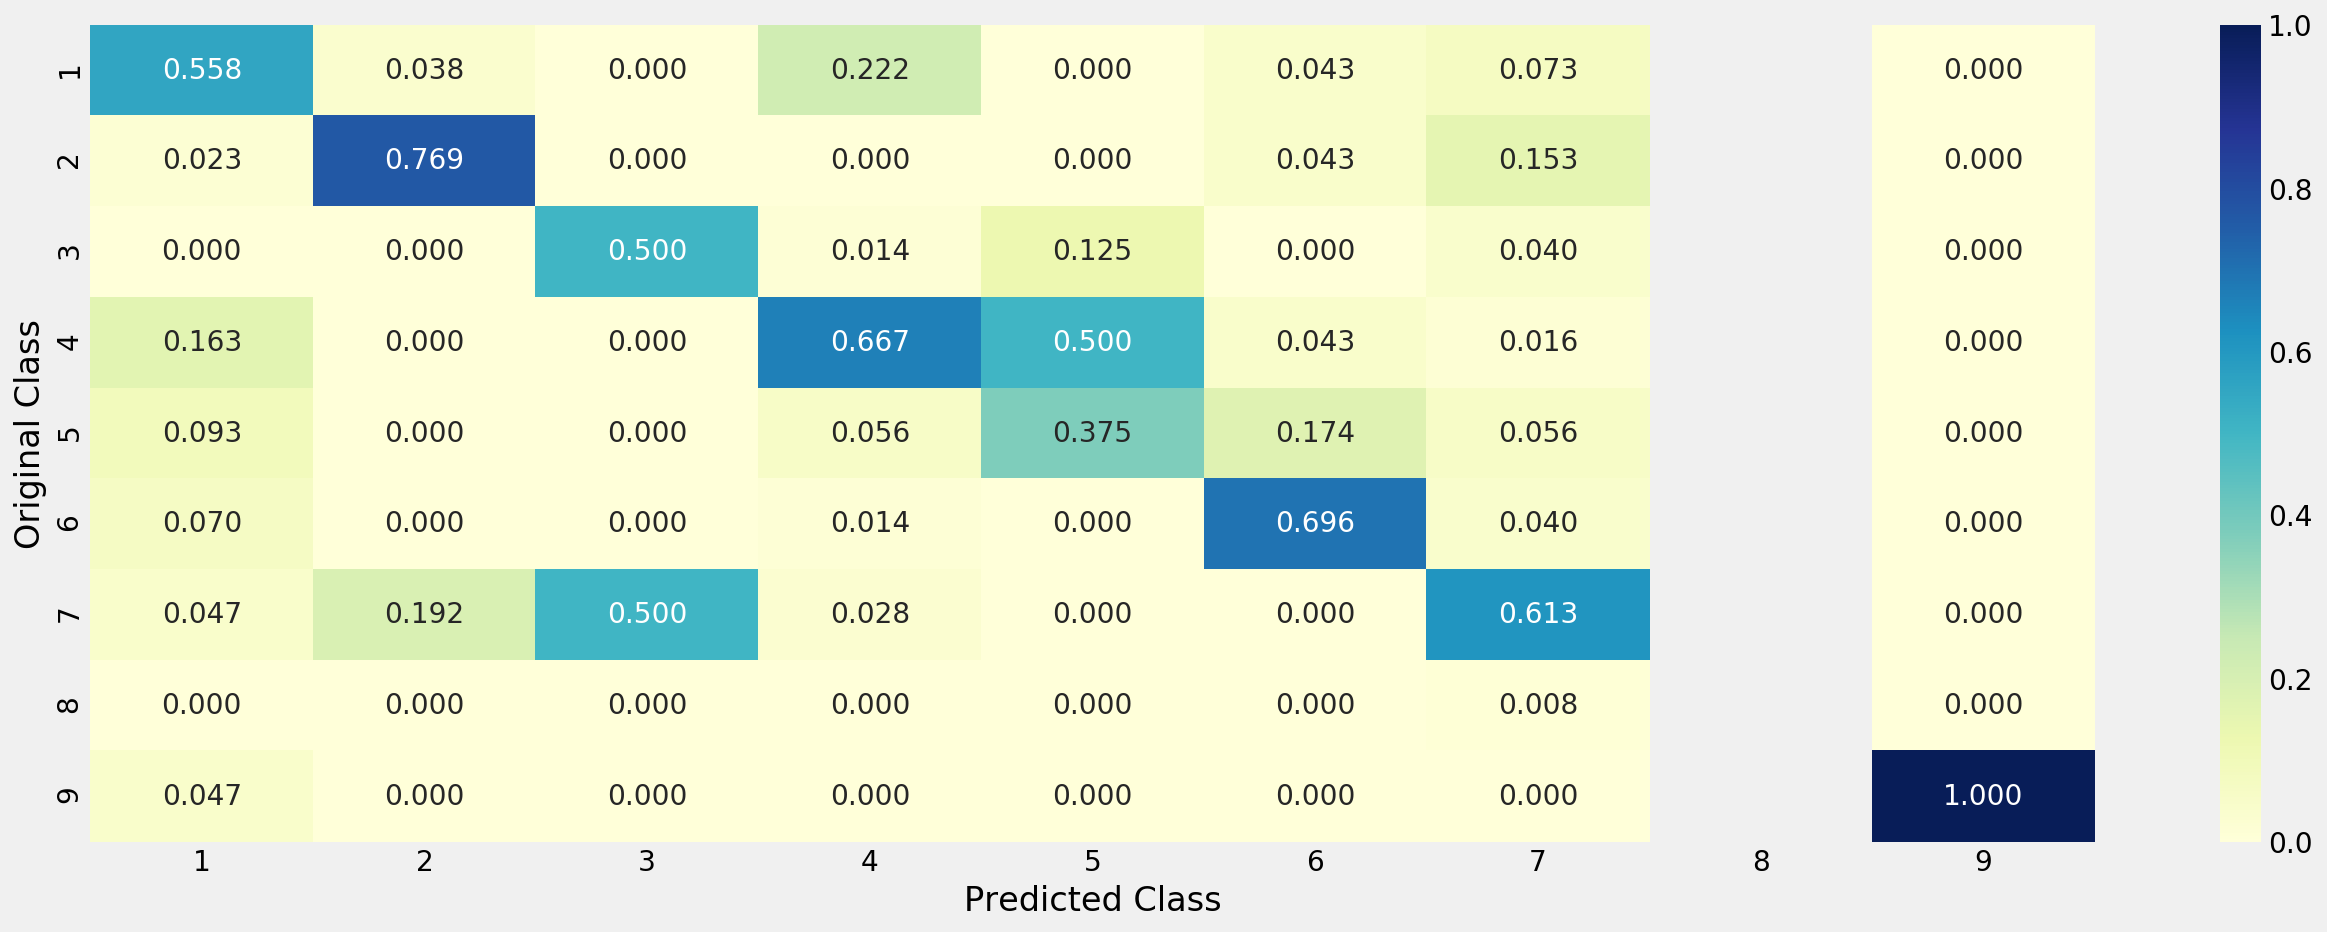

-------------------- Recall matrix (Row sum=1) --------------------


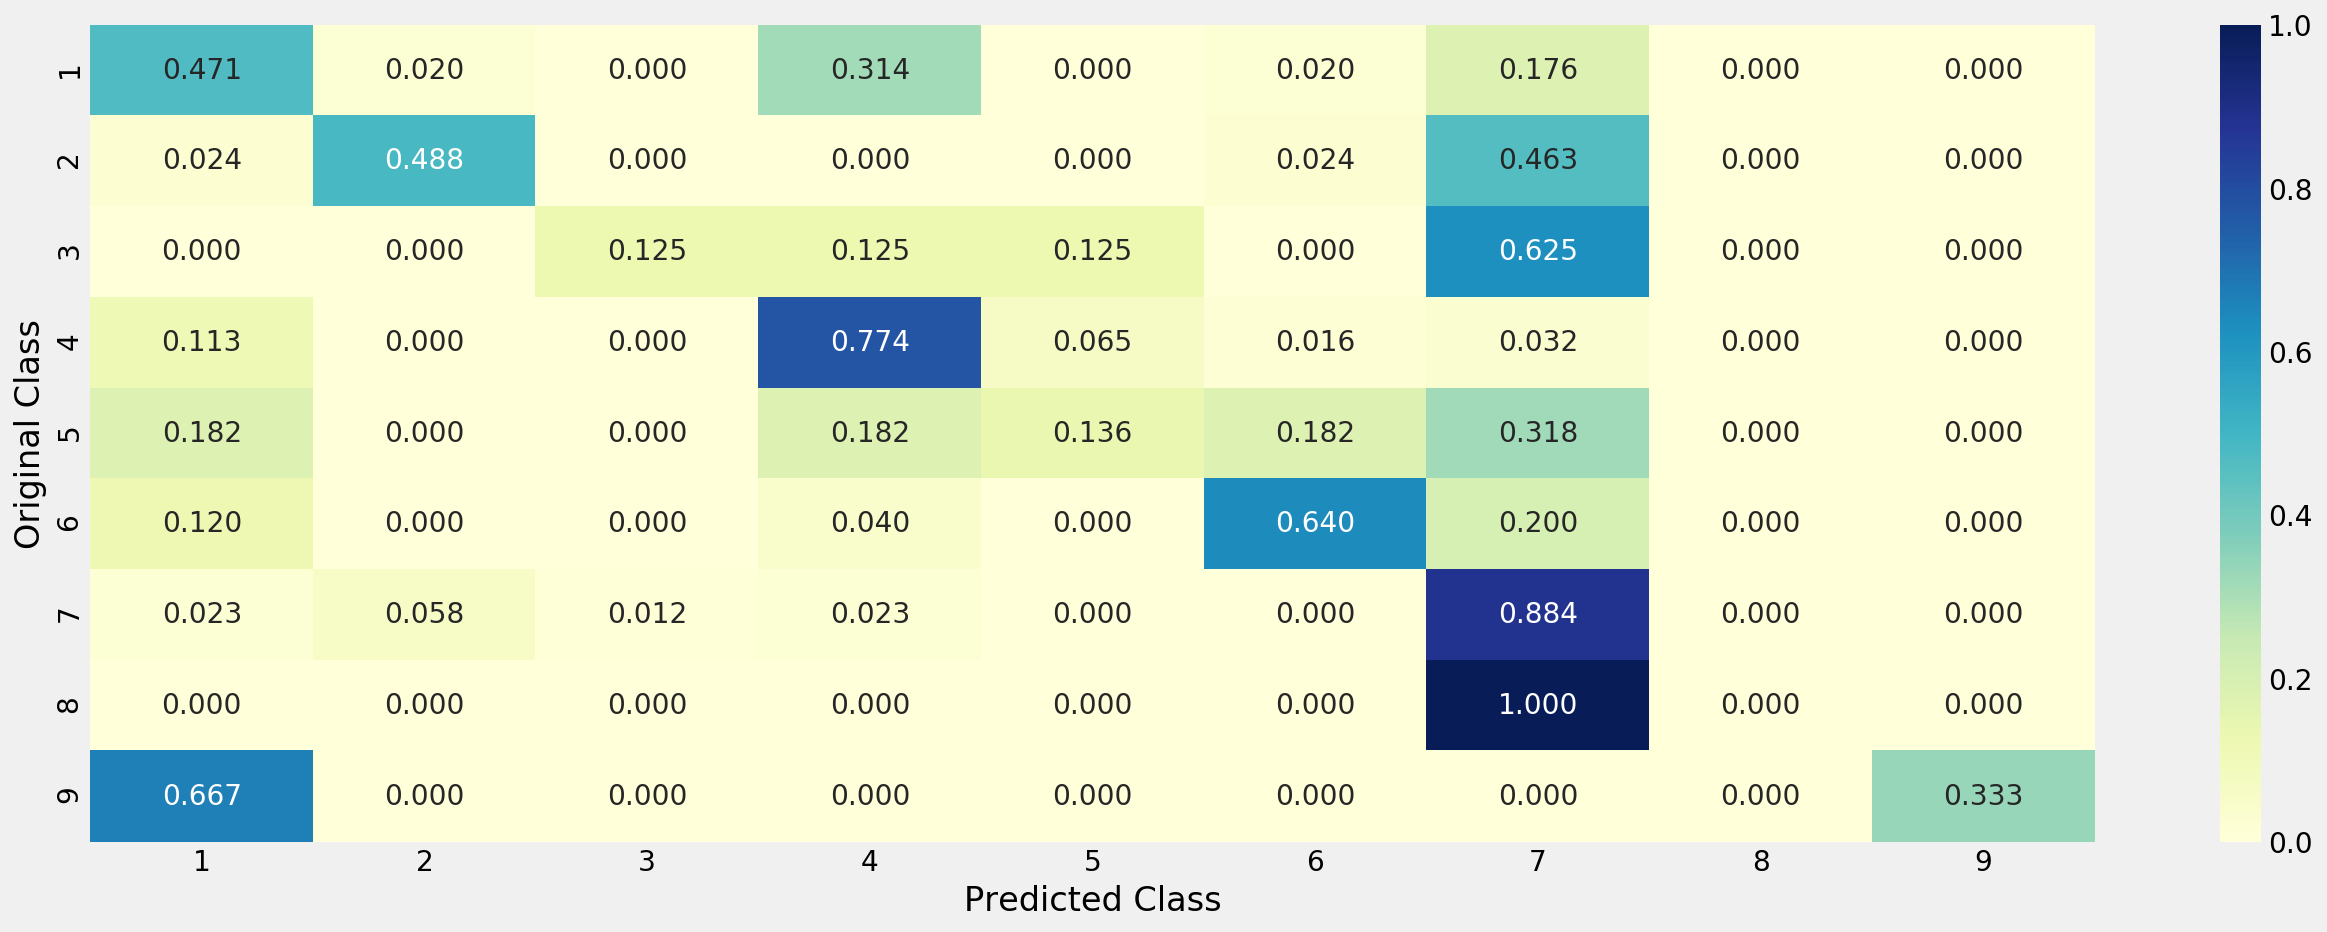

In [53]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x, train_y,cv_x,cv_y, clf)

<h2> Random Forests </h2>

In [54]:
from datetime import datetime
from  tqdm import tqdm

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

for n_estimators = 100 and max depth =  5
Log Loss : 1.2166923518382513



 17%|██████████████                                                                      | 1/6 [00:17<01:27, 17.51s/it]

for n_estimators = 100 and max depth =  10
Log Loss : 1.1214424610235842



 33%|████████████████████████████                                                        | 2/6 [01:59<02:51, 42.98s/it]

for n_estimators = 100 and max depth =  20
Log Loss : 1.0847373350228322



 50%|█████████████████████████████████████████▌                                         | 3/6 [10:01<08:43, 174.42s/it]

for n_estimators = 100 and max depth =  30
Log Loss : 1.089448782799856



 67%|███████████████████████████████████████████████████████▎                           | 4/6 [22:39<11:39, 349.53s/it]

for n_estimators = 100 and max depth =  40
Log Loss : 1.0971287380201349



 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [35:51<08:02, 482.31s/it]

for n_estimators = 100 and max depth =  50
Log Loss : 1.092231828189744



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

for n_estimators = 200 and max depth =  5
Log Loss : 1.2056294220193609



 17%|██████████████                                                                      | 1/6 [00:32<02:44, 32.86s/it]

for n_estimators = 200 and max depth =  10
Log Loss : 1.1140433422412768



 33%|████████████████████████████                                                        | 2/6 [04:00<05:41, 85.39s/it]

for n_estimators = 200 and max depth =  20
Log Loss : 1.081061890269118



 50%|█████████████████████████████████████████▌                                         | 3/6 [19:38<17:02, 340.99s/it]

for n_estimators = 200 and max depth =  30
Log Loss : 1.088559141686943



 67%|███████████████████████████████████████████████████████▎                           | 4/6 [56:46<30:14, 907.27s/it]

for n_estimators = 200 and max depth =  40
Log Loss : 1.0872142669524871



 83%|██████████████████████████████████████████████████████████████████▋             | 5/6 [1:38:17<23:02, 1382.31s/it]

for n_estimators = 200 and max depth =  50
Log Loss : 1.0868659911387075



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

for n_estimators = 500 and max depth =  5
Log Loss : 1.2008370286321337



 17%|██████████████                                                                      | 1/6 [01:07<05:36, 67.25s/it]

for n_estimators = 500 and max depth =  10
Log Loss : 1.1061368814257144



 33%|███████████████████████████▋                                                       | 2/6 [09:19<12:59, 194.80s/it]

for n_estimators = 500 and max depth =  20
Log Loss : 1.0782854115882547



 50%|█████████████████████████████████████████▌                                         | 3/6 [48:41<42:14, 844.79s/it]

for n_estimators = 500 and max depth =  30
Log Loss : 1.0852747137399674



 67%|█████████████████████████████████████████████████████▎                          | 4/6 [1:46:41<54:31, 1635.54s/it]

for n_estimators = 500 and max depth =  40
Log Loss : 1.0875844567721262



 83%|██████████████████████████████████████████████████████████████████▋             | 5/6 [2:50:50<38:19, 2299.42s/it]

for n_estimators = 500 and max depth =  50
Log Loss : 1.0887000004230862



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

for n_estimators = 1000 and max depth =  5
Log Loss : 1.1974526990532648



 17%|█████████████▊                                                                     | 1/6 [02:11<10:55, 131.02s/it]

for n_estimators = 1000 and max depth =  10
Log Loss : 1.1019984981351152



 33%|███████████████████████████▋                                                       | 2/6 [18:02<25:08, 377.16s/it]

for n_estimators = 1000 and max depth =  20
Log Loss : 1.078093481082255



 50%|███████████████████████████████████████                                       | 3/6 [1:32:27<1:20:10, 1603.48s/it]

for n_estimators = 1000 and max depth =  30
Log Loss : 1.085764729410388



 67%|████████████████████████████████████████████████████                          | 4/6 [3:26:30<1:45:50, 3175.29s/it]

for n_estimators = 1000 and max depth =  40
Log Loss : 1.0869862275876006



 83%|█████████████████████████████████████████████████████████████████             | 5/6 [5:36:49<1:16:08, 4568.59s/it]

for n_estimators = 1000 and max depth =  50
Log Loss : 1.088239450373662



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

for n_estimators = 1500 and max depth =  5
Log Loss : 1.199179999208933



 17%|█████████████▊                                                                     | 1/6 [03:21<16:48, 201.63s/it]

for n_estimators = 1500 and max depth =  10
Log Loss : 1.1037350366904153



 33%|███████████████████████████▋                                                       | 2/6 [26:44<37:28, 562.11s/it]

for n_estimators = 1500 and max depth =  20
Log Loss : 1.0781450143347884



 50%|███████████████████████████████████████                                       | 3/6 [2:44:28<2:23:37, 2872.45s/it]

for n_estimators = 1500 and max depth =  30
Log Loss : 1.0871976764640936



 67%|████████████████████████████████████████████████████                          | 4/6 [6:05:02<3:07:21, 5620.95s/it]

for n_estimators = 1500 and max depth =  40
Log Loss : 1.0885933069112237



 83%|█████████████████████████████████████████████████████████████████             | 5/6 [9:23:28<2:05:06, 7506.61s/it]

for n_estimators = 1500 and max depth =  50
Log Loss : 1.0882258051530378



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

for n_estimators = 2000 and max depth =  5
Log Loss : 1.1982173746950862



 17%|█████████████▊                                                                     | 1/6 [04:28<22:21, 268.38s/it]

for n_estimators = 2000 and max depth =  10
Log Loss : 1.1047575755794399



 33%|███████████████████████████▋                                                       | 2/6 [35:49<50:08, 752.05s/it]

for n_estimators = 2000 and max depth =  20
Log Loss : 1.0783954315468658



 50%|███████████████████████████████████████                                       | 3/6 [3:32:12<3:05:04, 3701.39s/it]

for n_estimators = 2000 and max depth =  30
Log Loss : 1.0890584097692622



 67%|████████████████████████████████████████████████████                          | 4/6 [7:54:16<4:03:36, 7308.39s/it]

for n_estimators = 2000 and max depth =  40
Log Loss : 1.089747619189907



 83%|███████████████████████████████████████████████████████████████▎            | 5/6 [12:34:55<2:49:27, 10167.45s/it]

for n_estimators = 2000 and max depth =  50
Log Loss : 1.0899347789724503



100%|██████████████████████████████████████████████████████████████████████████████| 6/6 [45:26:00<00:00, 35735.84s/it]


IndexError: list index out of range

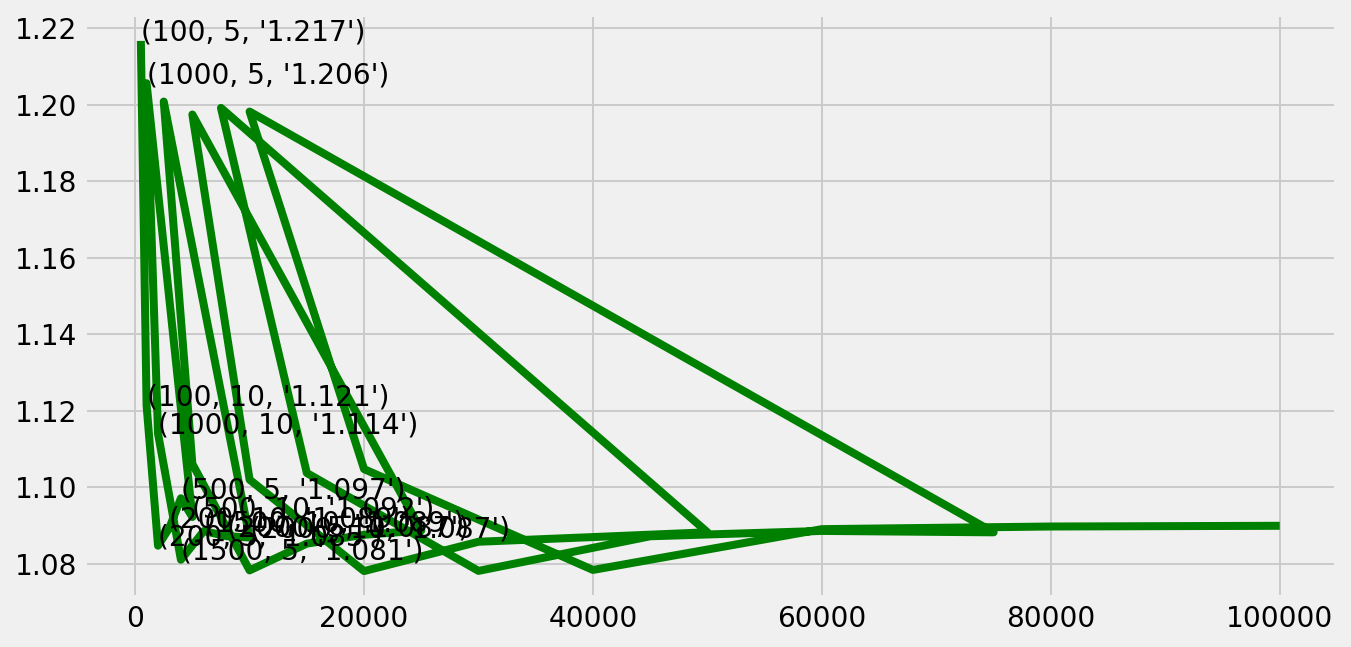

In [55]:
start = datetime.now()

tree = [100,200,500,1000,1500,2000]
max_depth = [5, 10,20,30,40,50]
cv_log_error_array = []
for i in tqdm(tree):
    for j in tqdm(max_depth):
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-3)
        clf.fit(train_x, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
"""
fig, ax = plt.subplots()
features = np.dot(np.array(tree)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((tree[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each tree")
plt.xlabel("tree i's")
plt.ylabel("Error measure")
plt.show()
"""

best_tree = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=tree[int(best_tree/2)], criterion='gini', max_depth=max_depth[int(best_tree%2)], random_state=42, n_jobs=-1)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best estimator = ', tree[int(best_tree/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best estimator = ', tree[int(best_tree/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best estimator = ', tree[int(best_tree/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Log loss : 1.078093481082255
Number of mis-classified points : 0.3411371237458194
-------------------- Confusion matrix --------------------


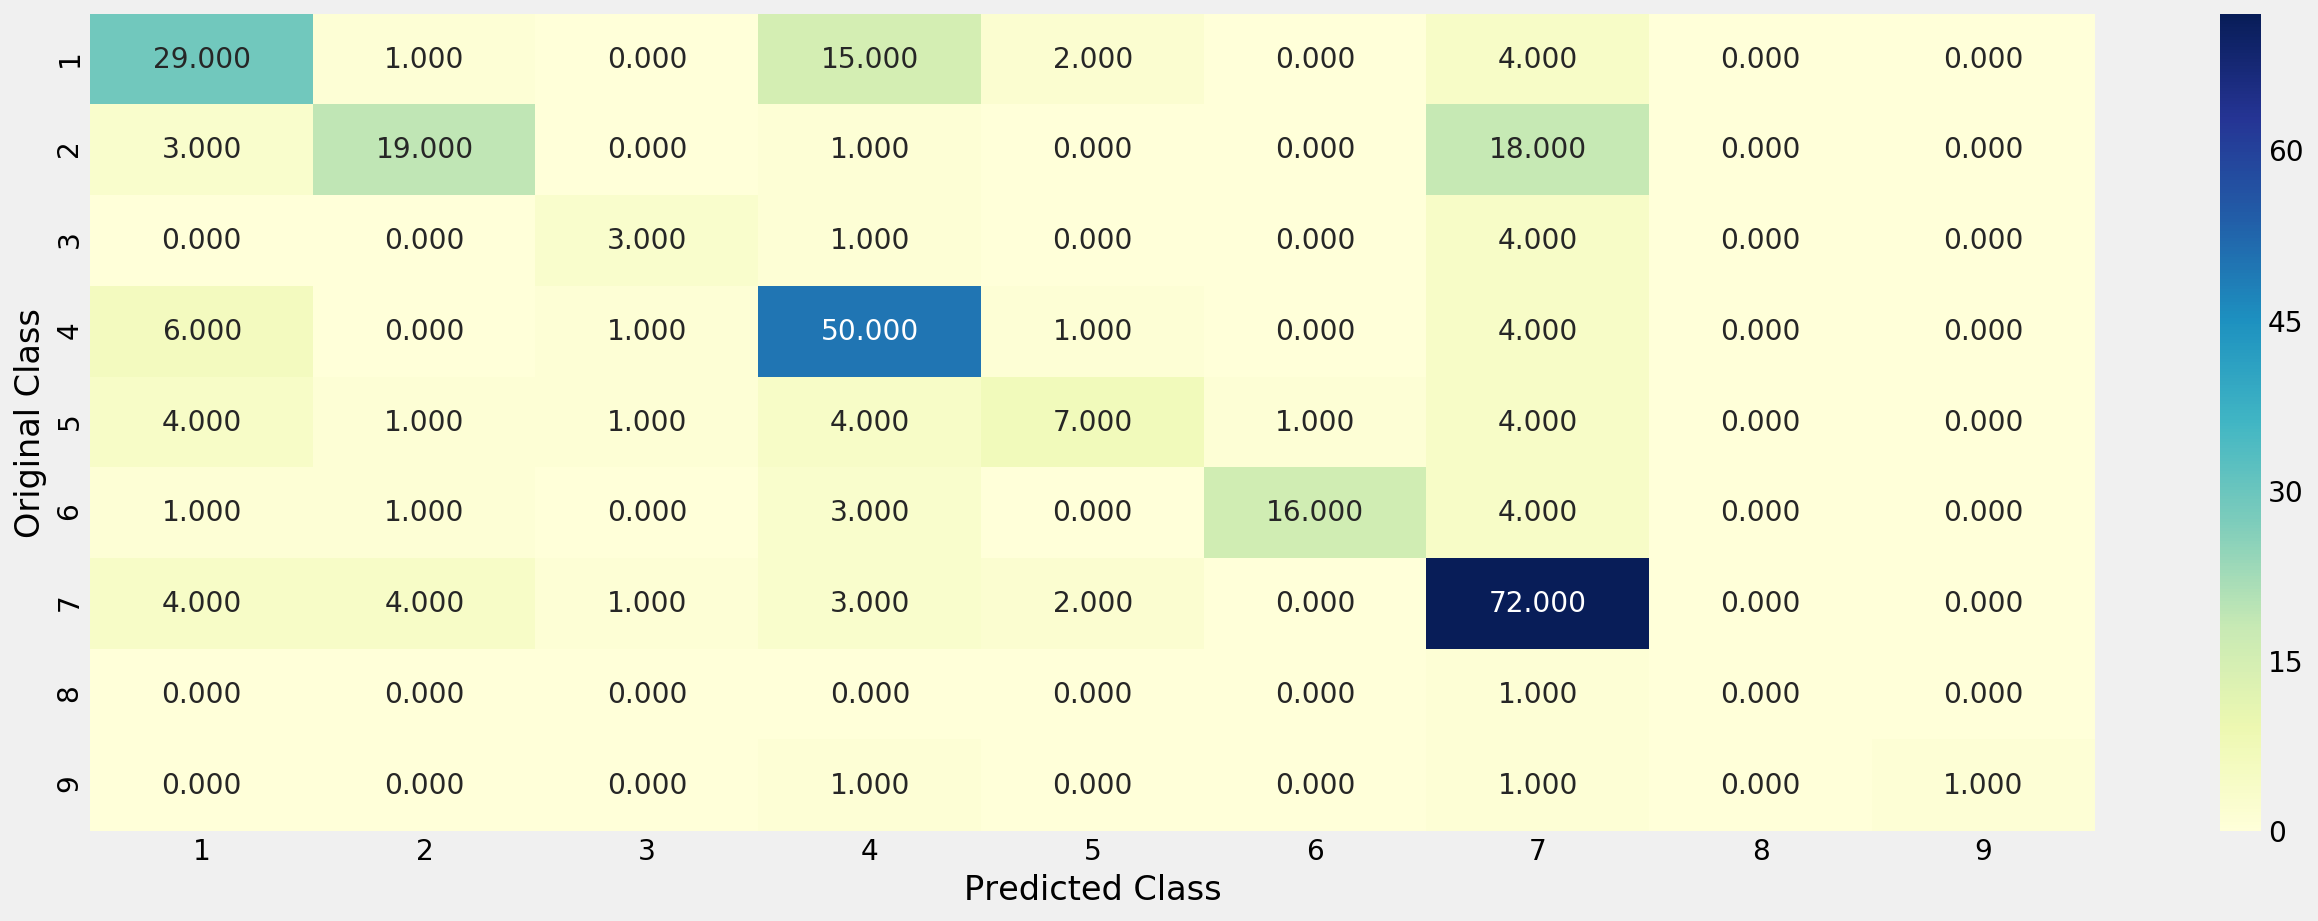

-------------------- Precision matrix (Columm Sum=1) --------------------


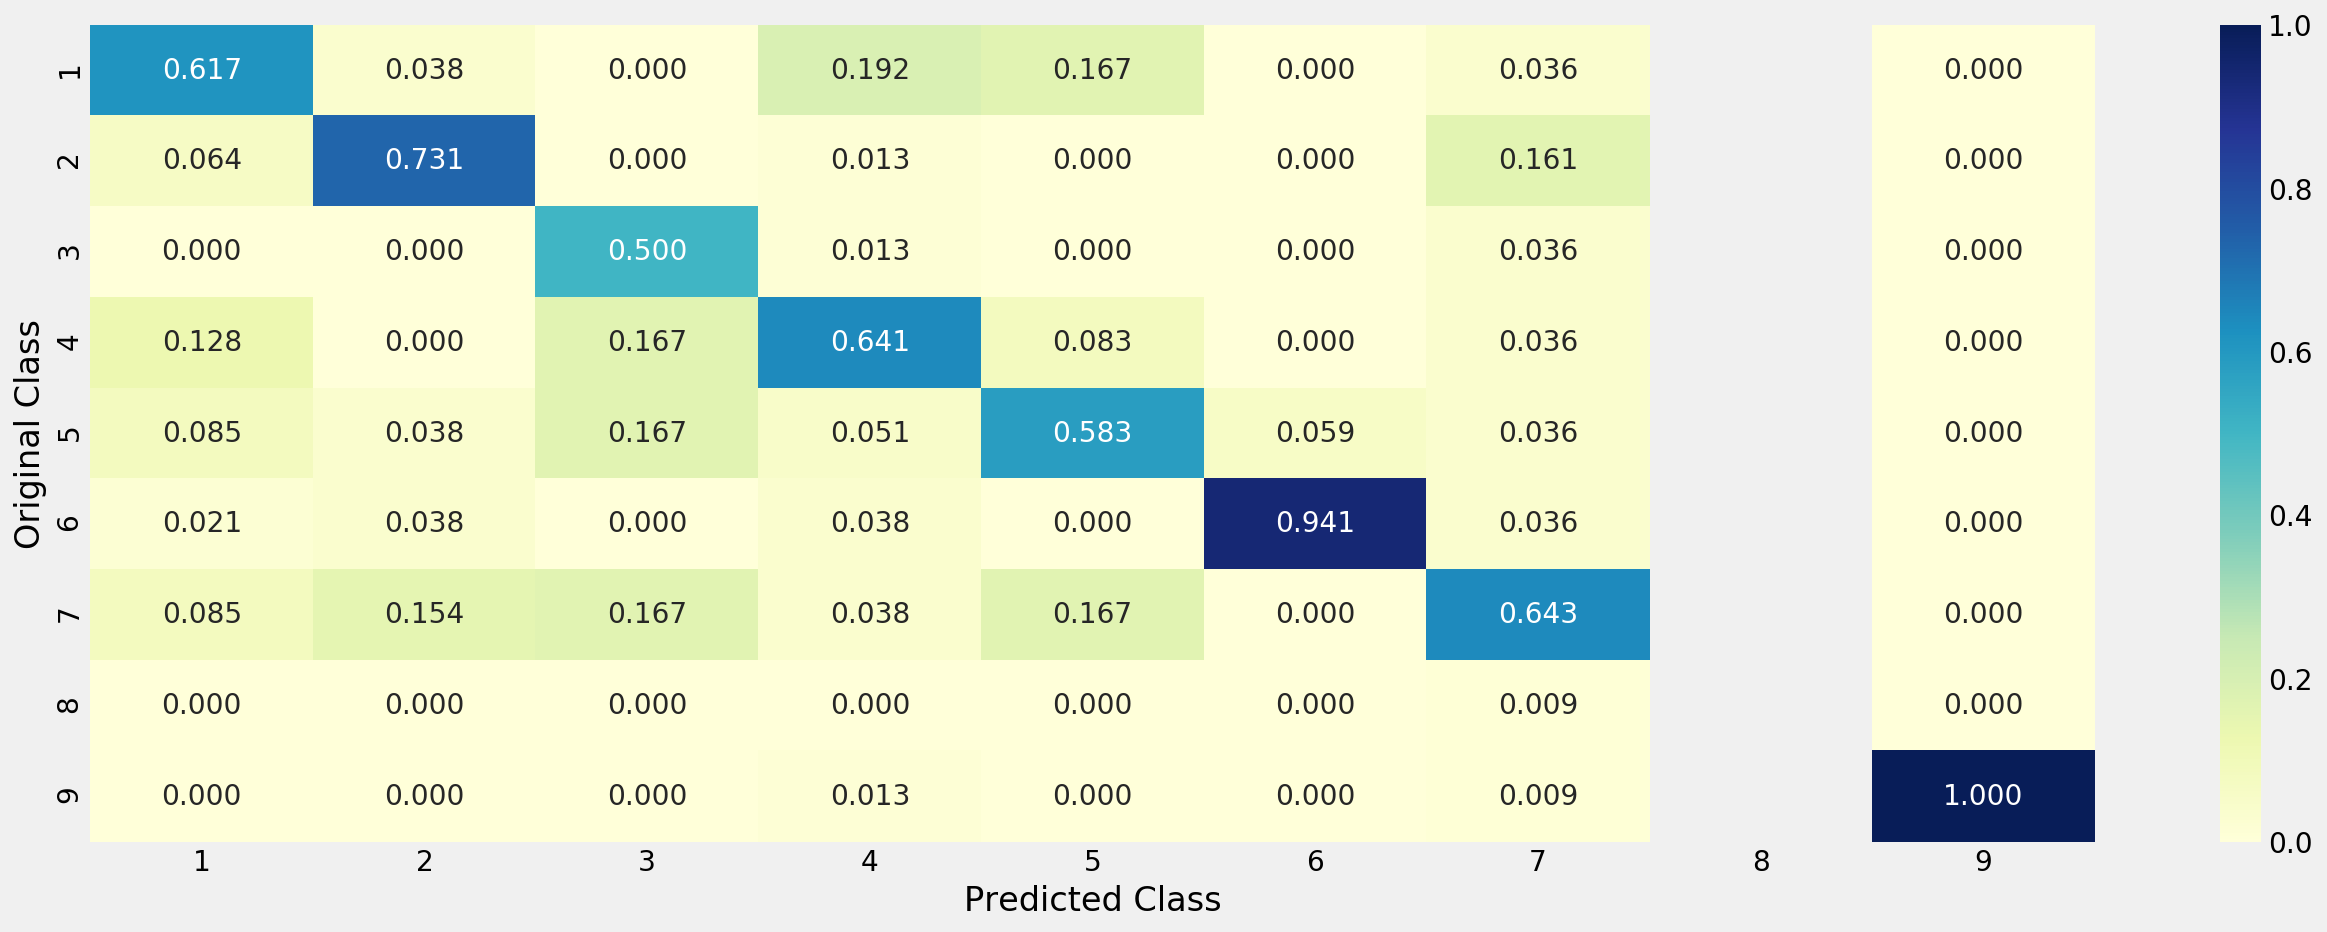

-------------------- Recall matrix (Row sum=1) --------------------


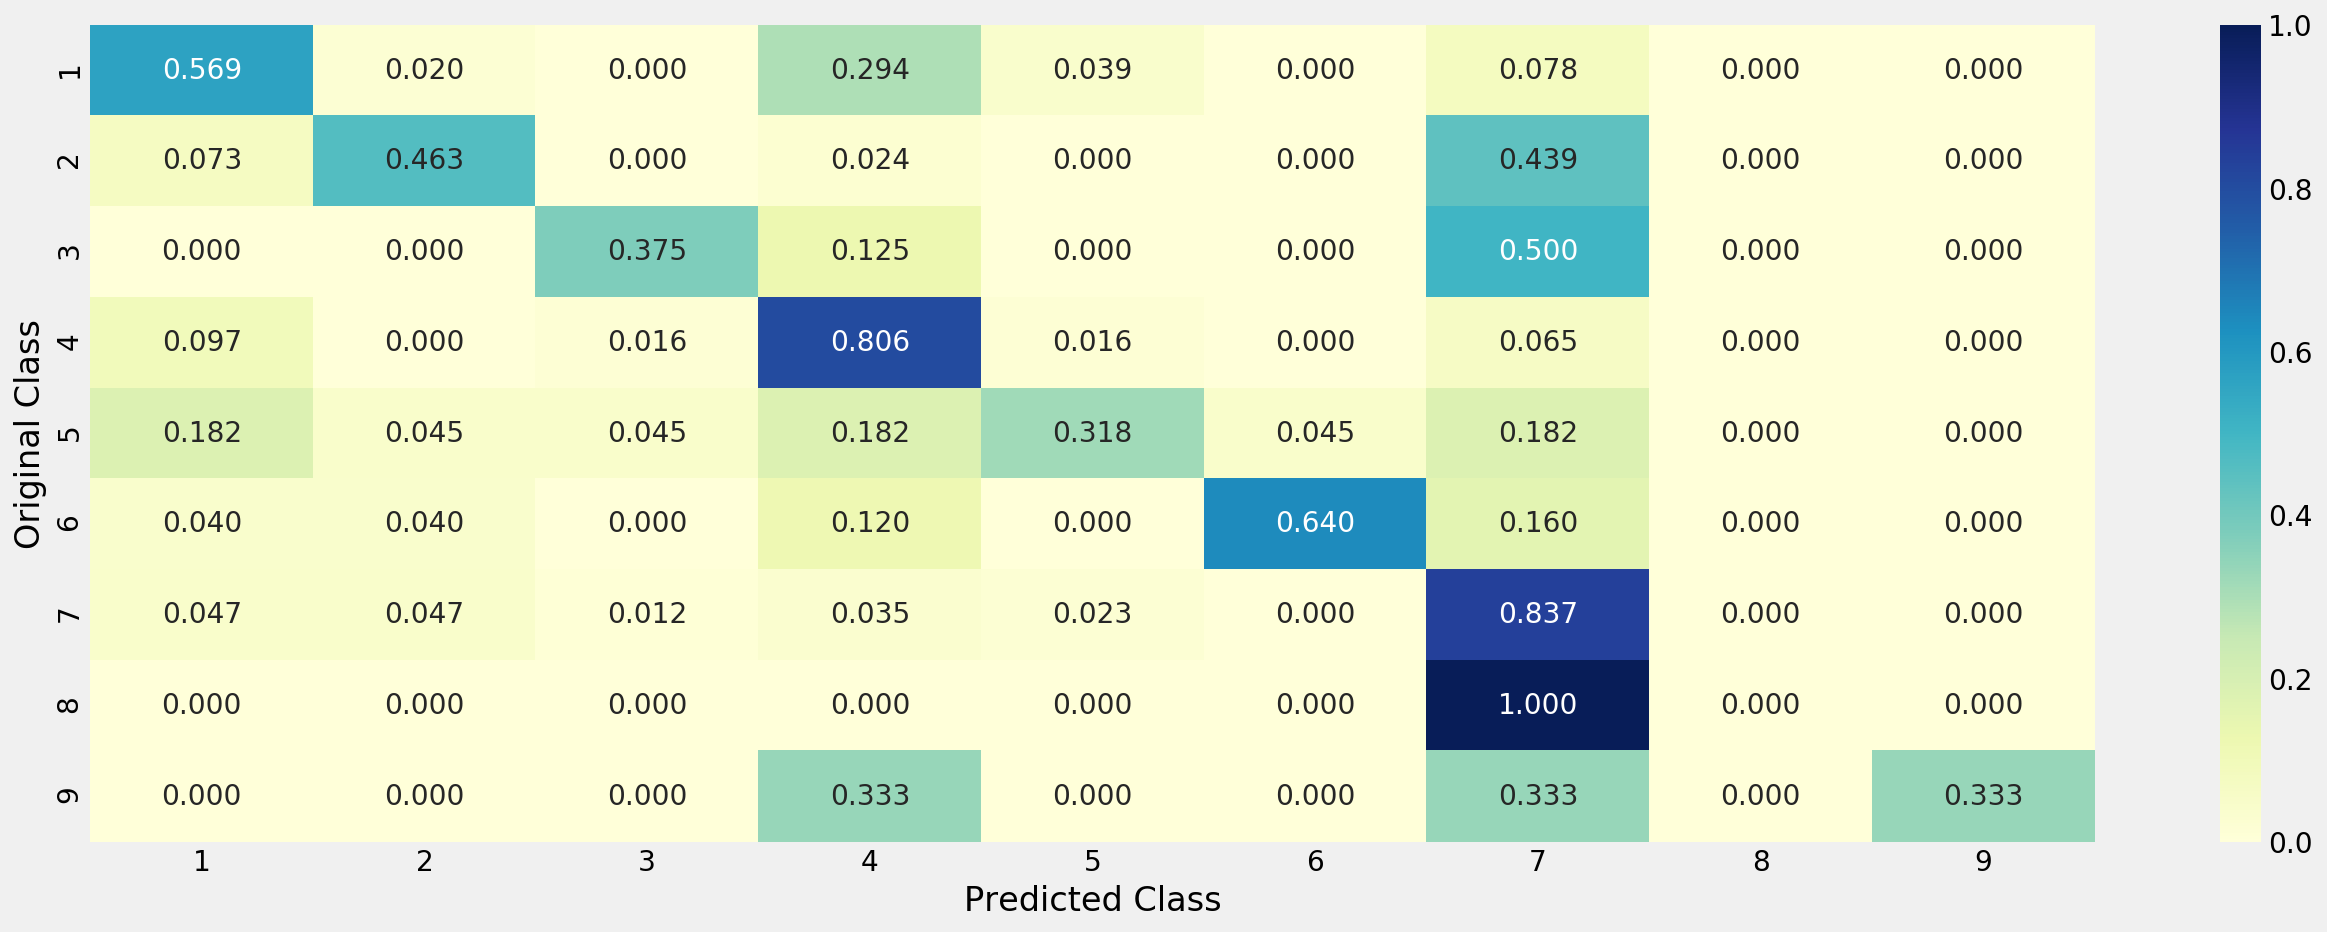

In [57]:
clf = RandomForestClassifier(n_estimators= 1000, criterion='gini', max_depth= 20, random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x, train_y,cv_x,cv_y, clf)

<h2> Stacking classifier </h2>

In [58]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x))))
sig_clf2.fit(train_x, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x))))
sig_clf3.fit(train_x, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.56
Support vector machines : Log Loss: 1.50
Naive Bayes : Log Loss: 1.38
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.179
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.065
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.710
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.334
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.219
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.226


Log loss (train) on the stacking classifier : 2.0554150119640435
Log loss (CV) on the stacking classifier : 2.064965800571497
Log loss (test) on the stacking classifier : 2.0659824940394644
Number of missclassified point : 0.6966966966966966
-------------------- Confusion matrix --------------------


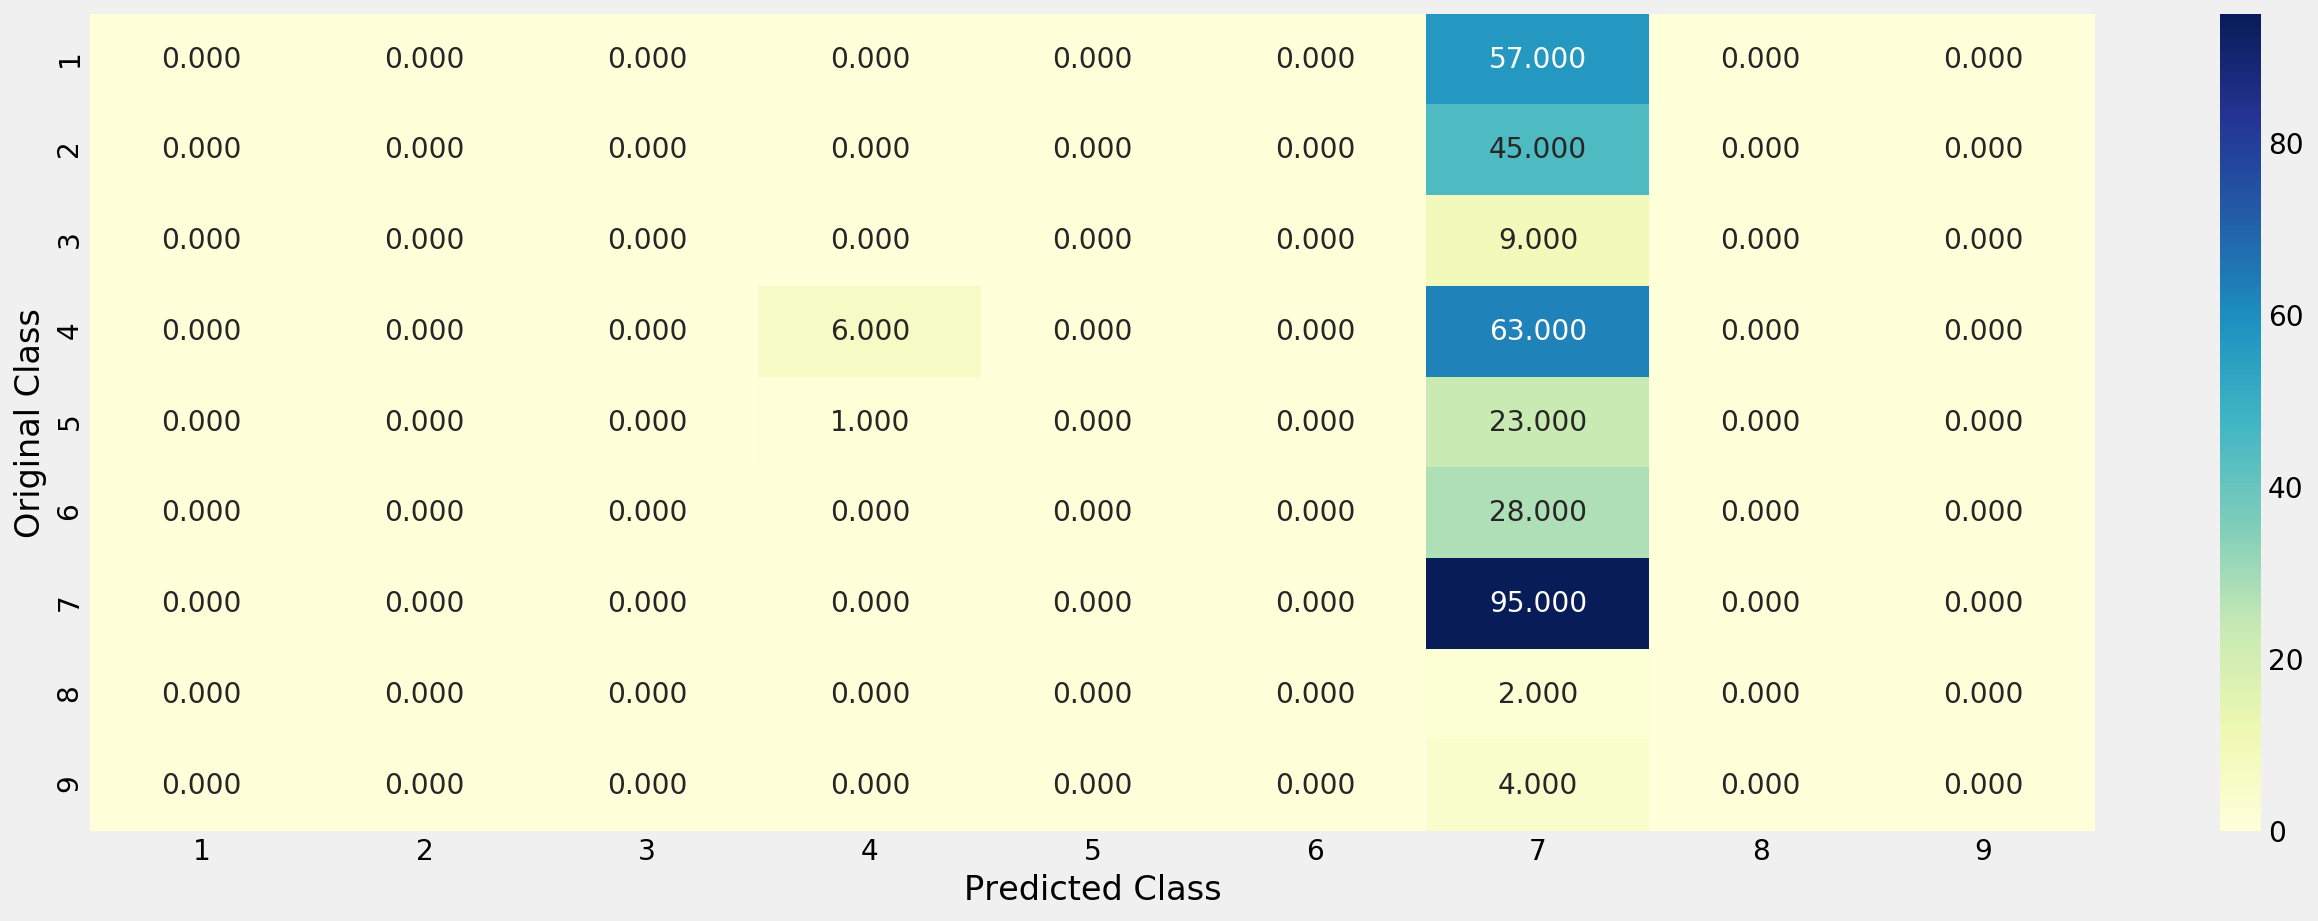

-------------------- Precision matrix (Columm Sum=1) --------------------


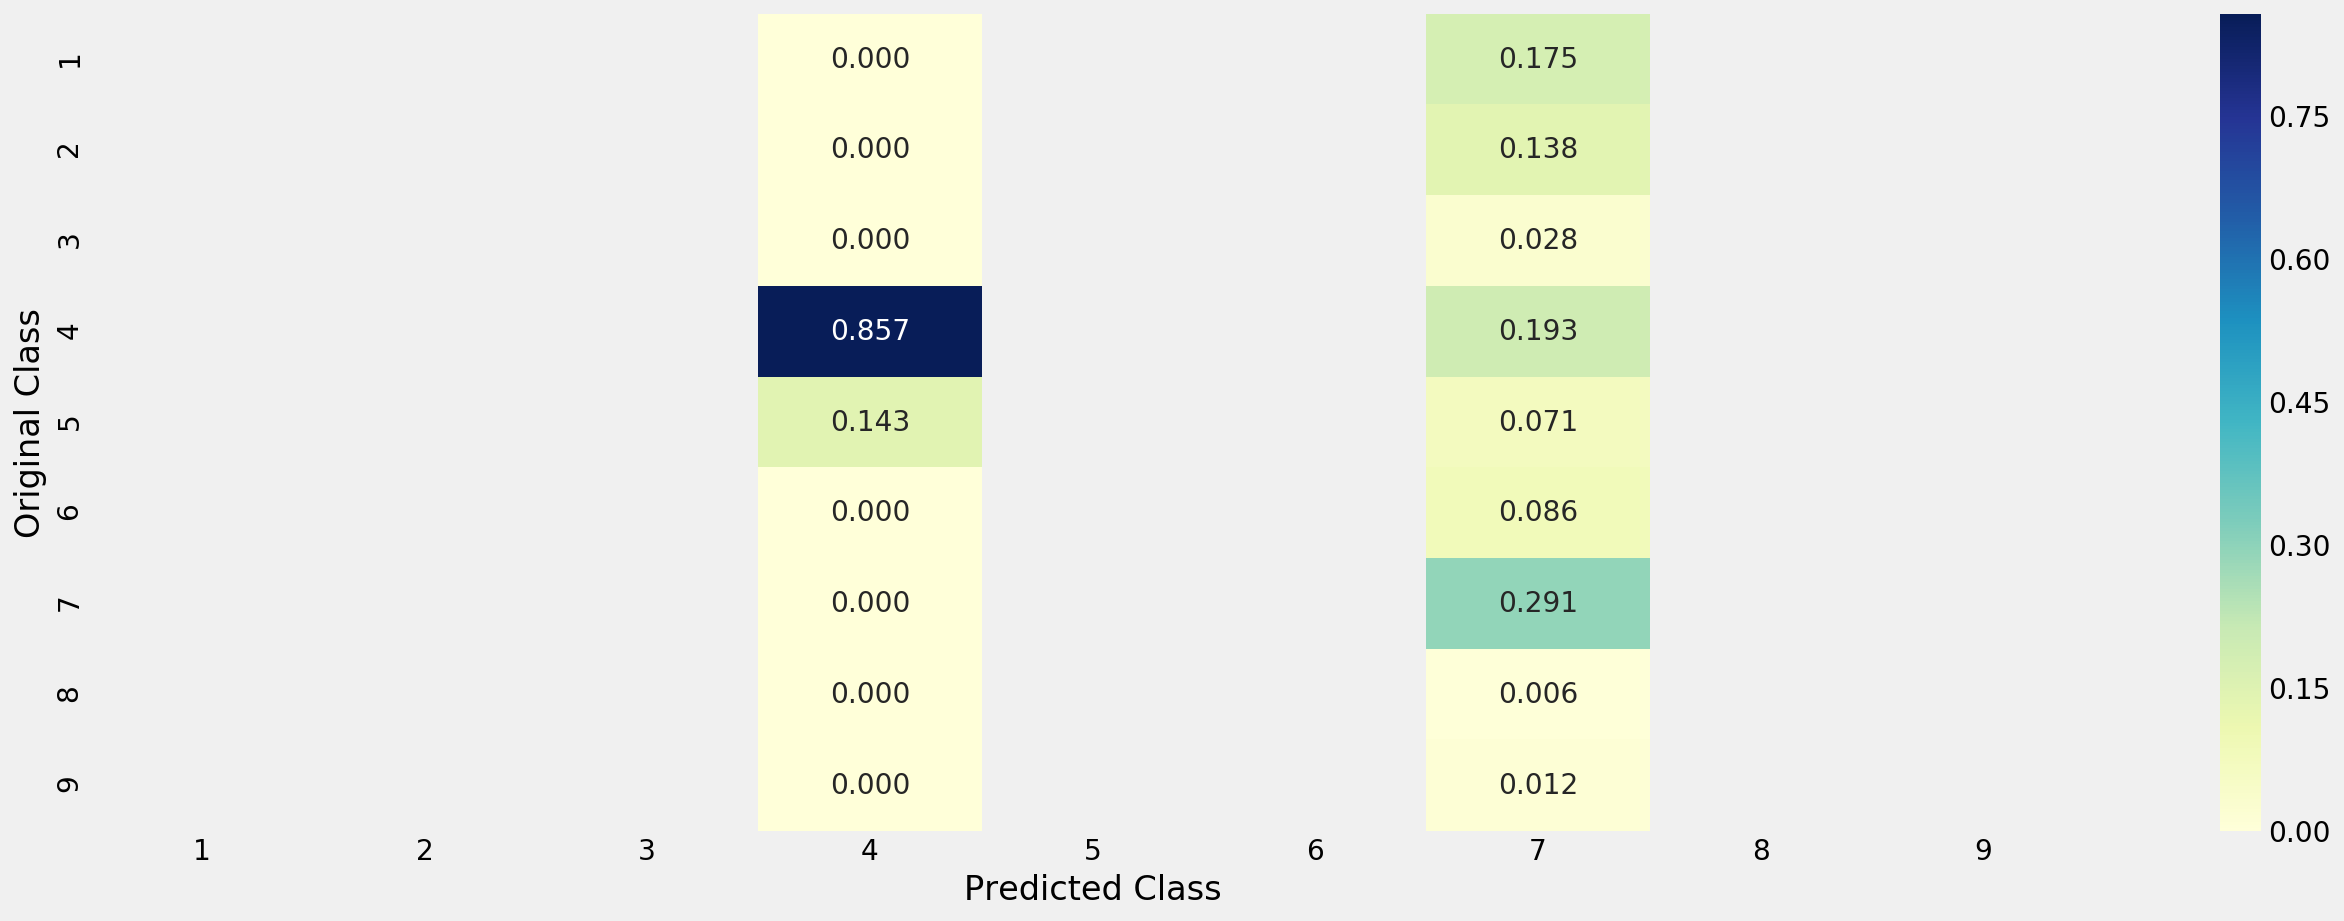

-------------------- Recall matrix (Row sum=1) --------------------


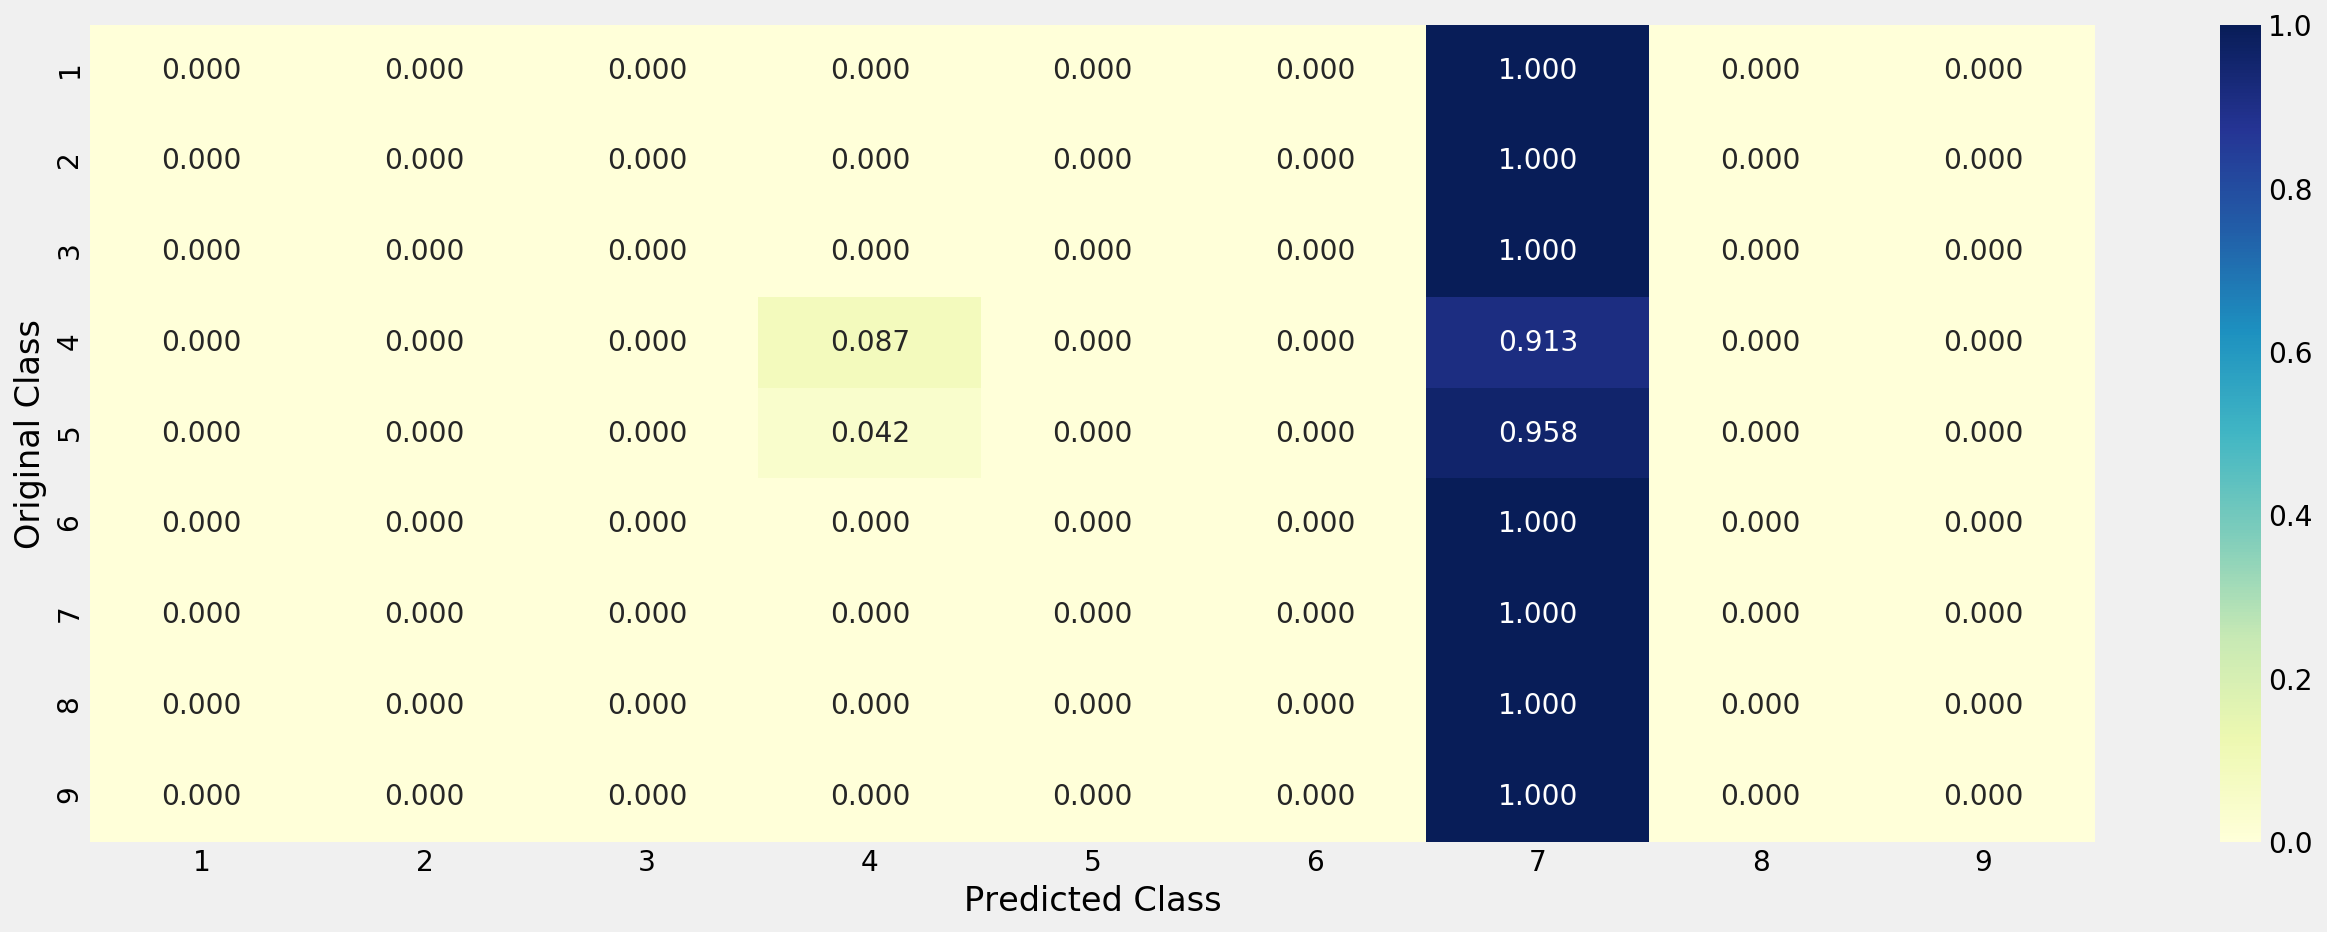

In [59]:
lr = LogisticRegression(C=0.001)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x))

<h2> Maxium Voting Classifier </h2>

Log loss (train) on the VotingClassifier : 1.201911654333764
Log loss (CV) on the VotingClassifier : 1.4278478555602974
Log loss (test) on the VotingClassifier : 1.4261350356114832
Number of missclassified point : 0.4294294294294294
-------------------- Confusion matrix --------------------


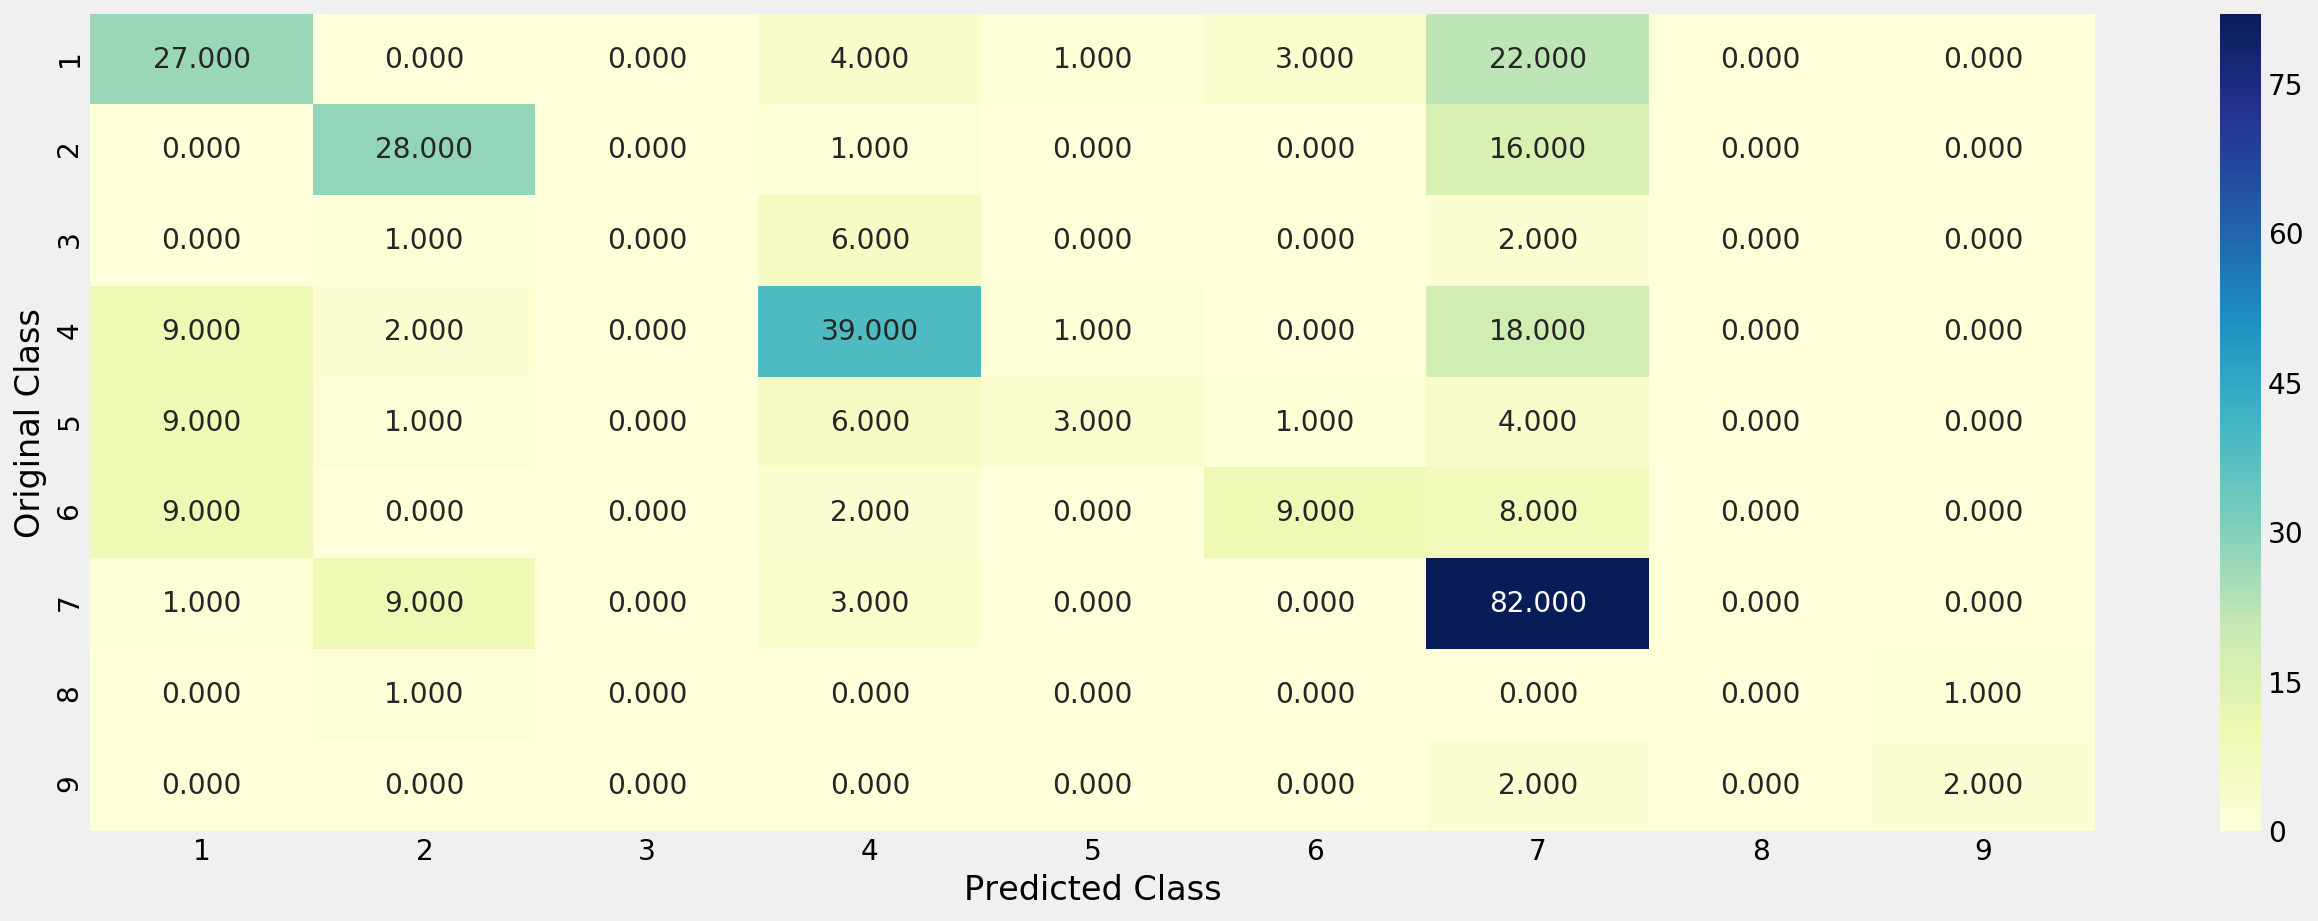

-------------------- Precision matrix (Columm Sum=1) --------------------


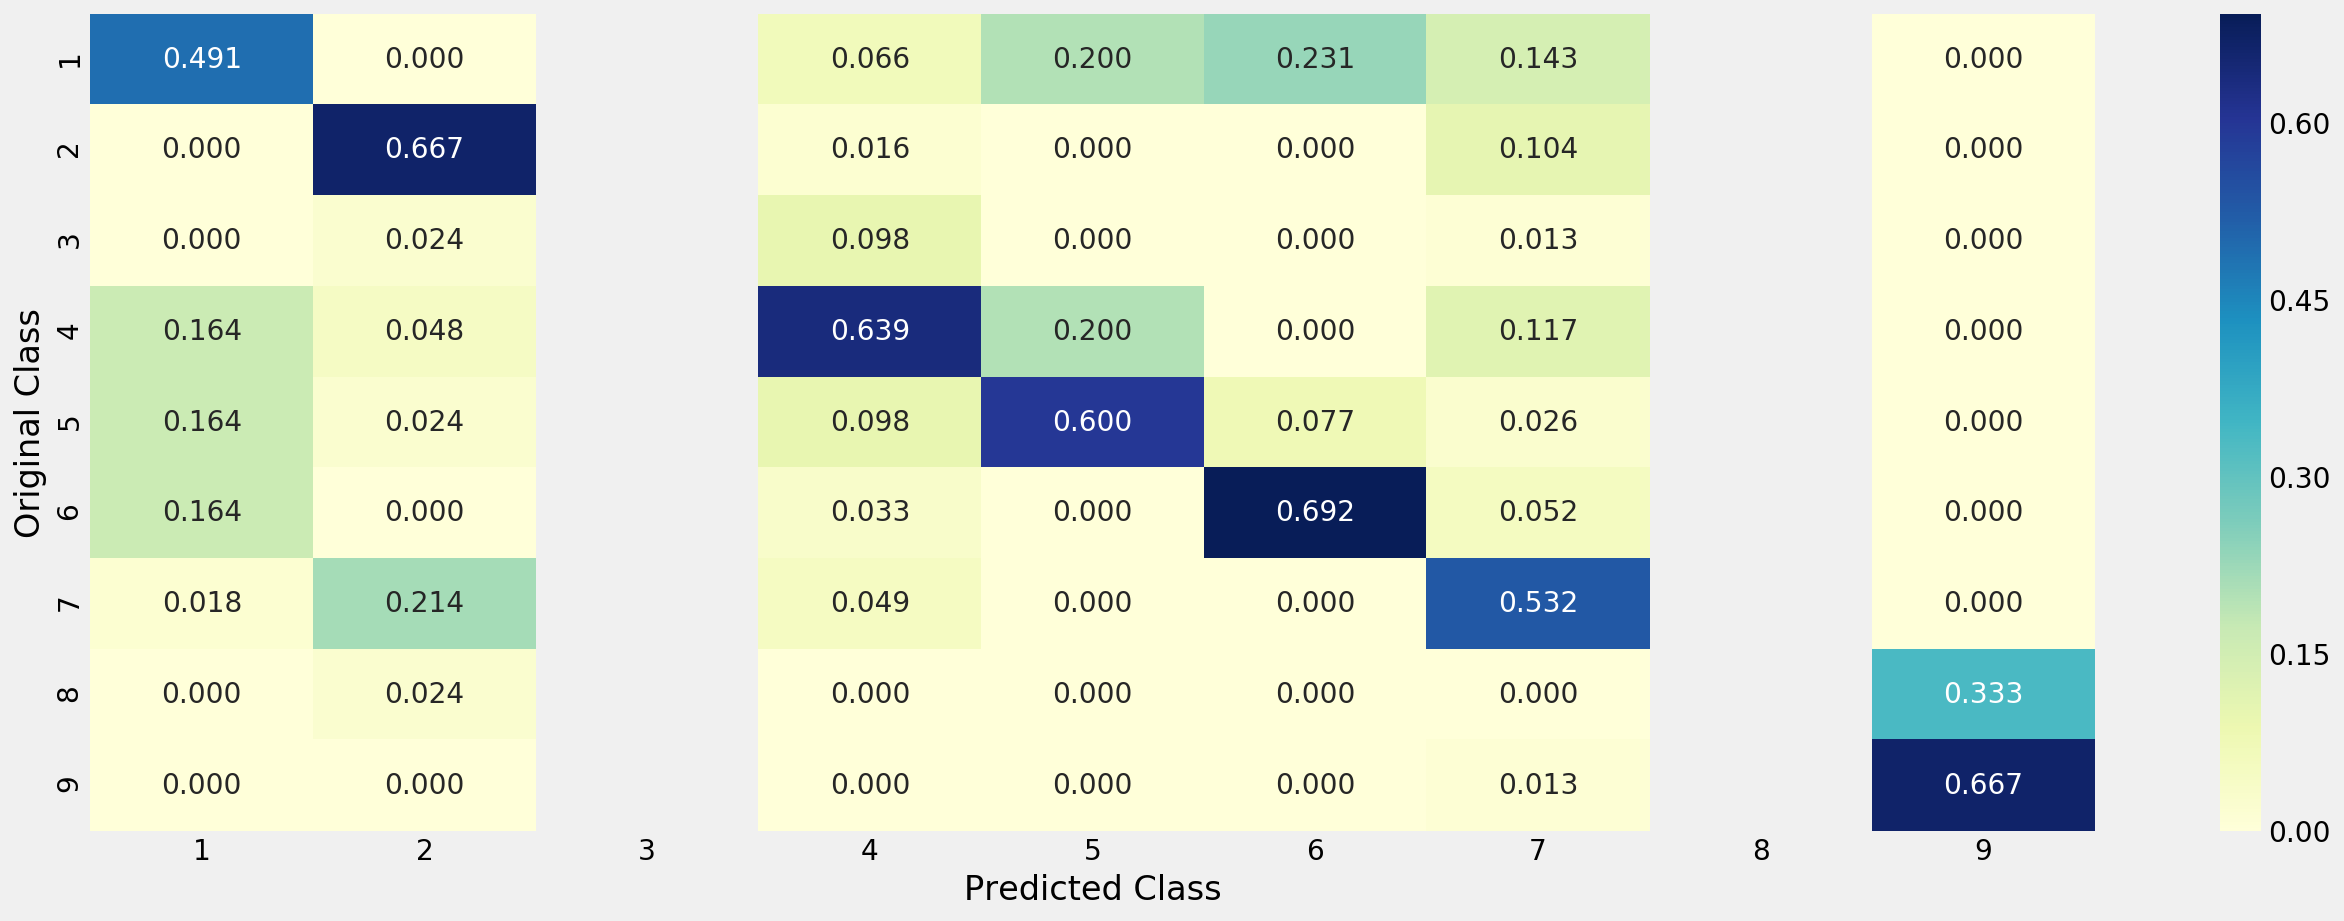

-------------------- Recall matrix (Row sum=1) --------------------


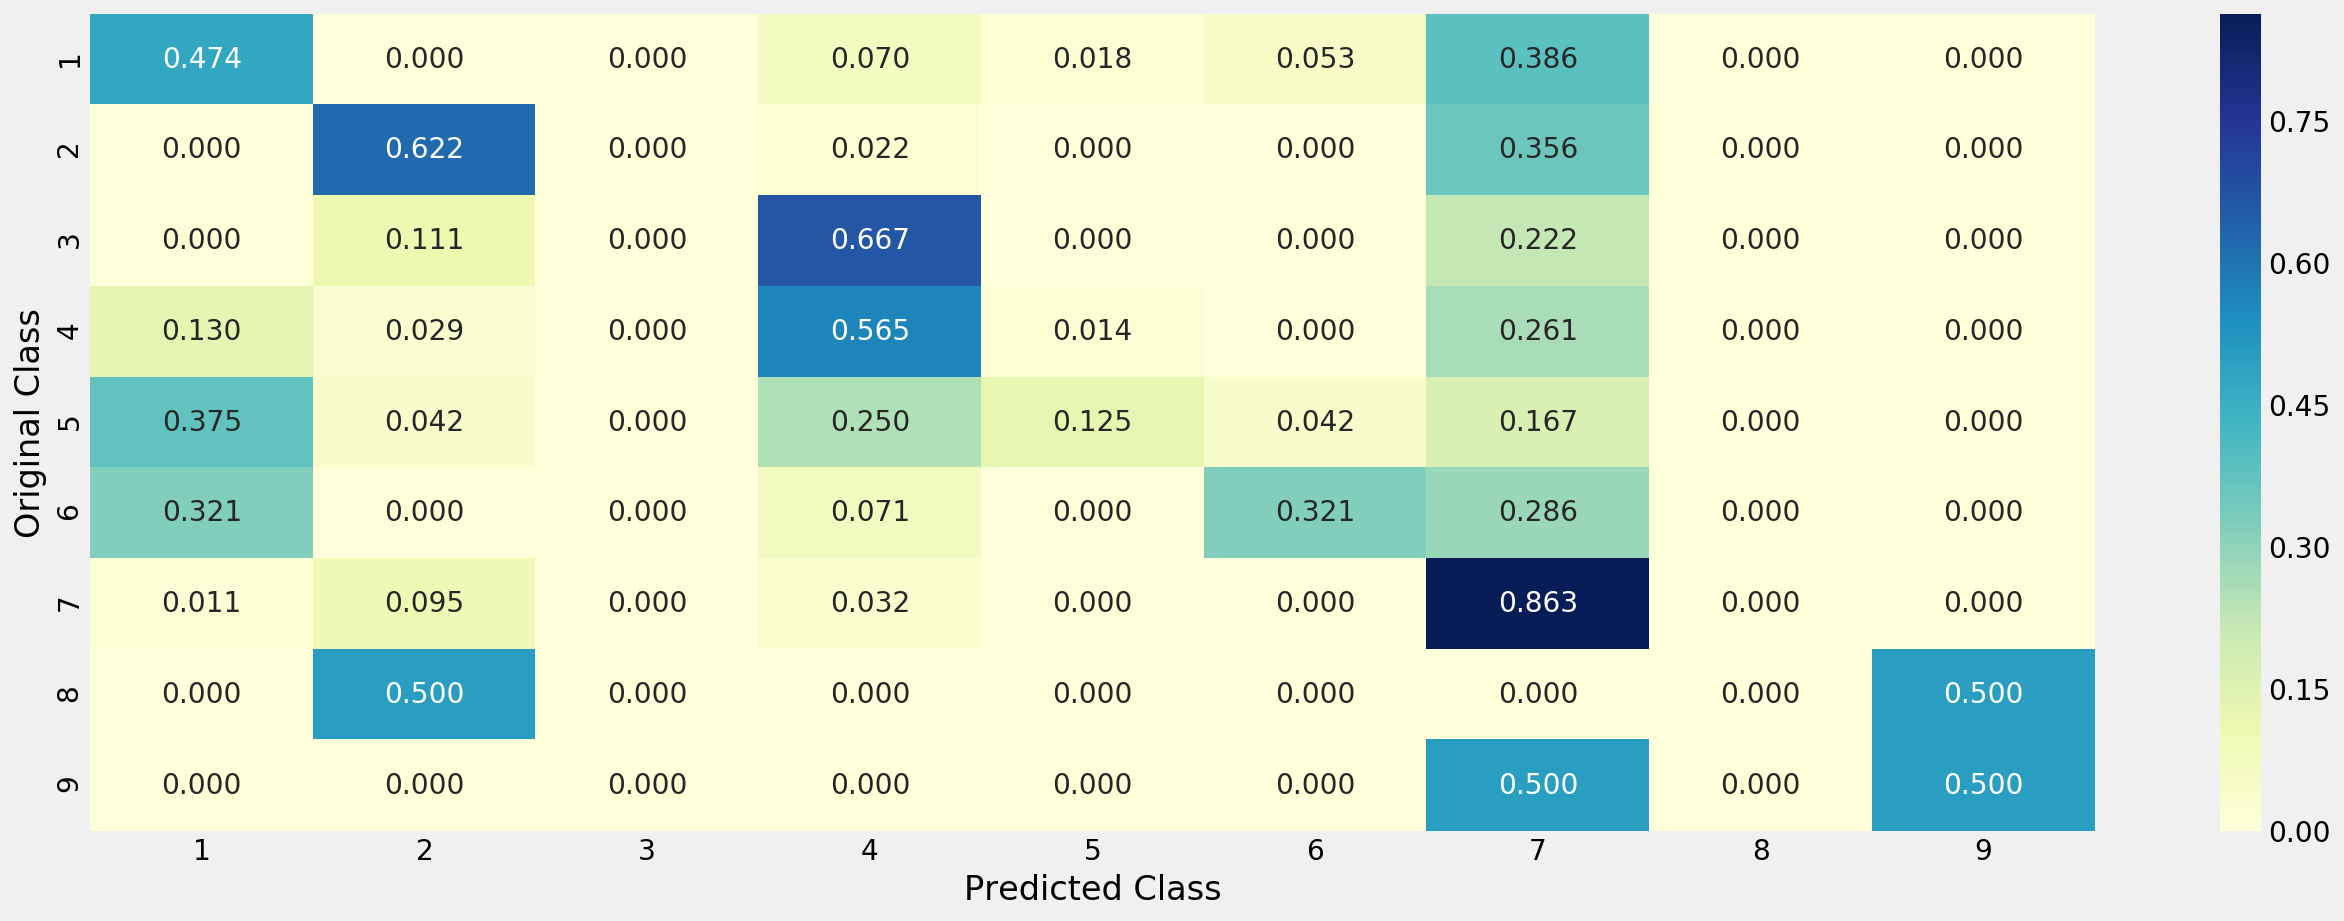

In [60]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x))

<h1> Linear SVM: </h1>

for alpha = 1e-06
Log Loss : 1.8115595668291105
for alpha = 1e-05
Log Loss : 1.526796803248679
for alpha = 0.0001
Log Loss : 1.4498297907988744
for alpha = 0.001
Log Loss : 1.4417101179958034
for alpha = 0.01
Log Loss : 1.4683908337276566
for alpha = 0.1
Log Loss : 1.4662619097436893
for alpha = 1
Log Loss : 1.4704233288048394


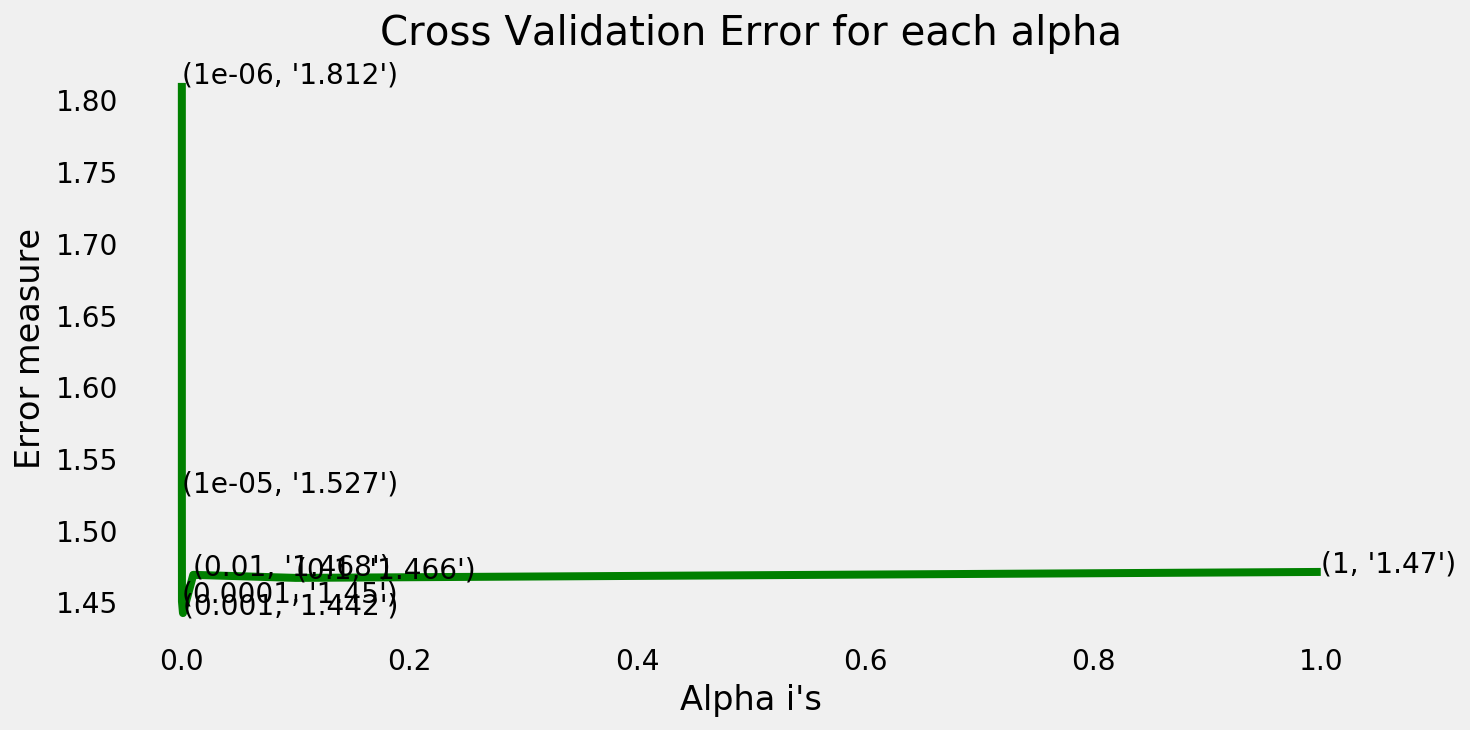

For values of best alpha =  0.001 The train log loss is: 1.1903209670286823
For values of best alpha =  0.001 The cross validation log loss is: 1.4462102226143665
For values of best alpha =  0.001 The test log loss is: 1.4733865577219307


In [61]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.4462102226143665
Number of mis-classified points : 0.411371237458194
-------------------- Confusion matrix --------------------


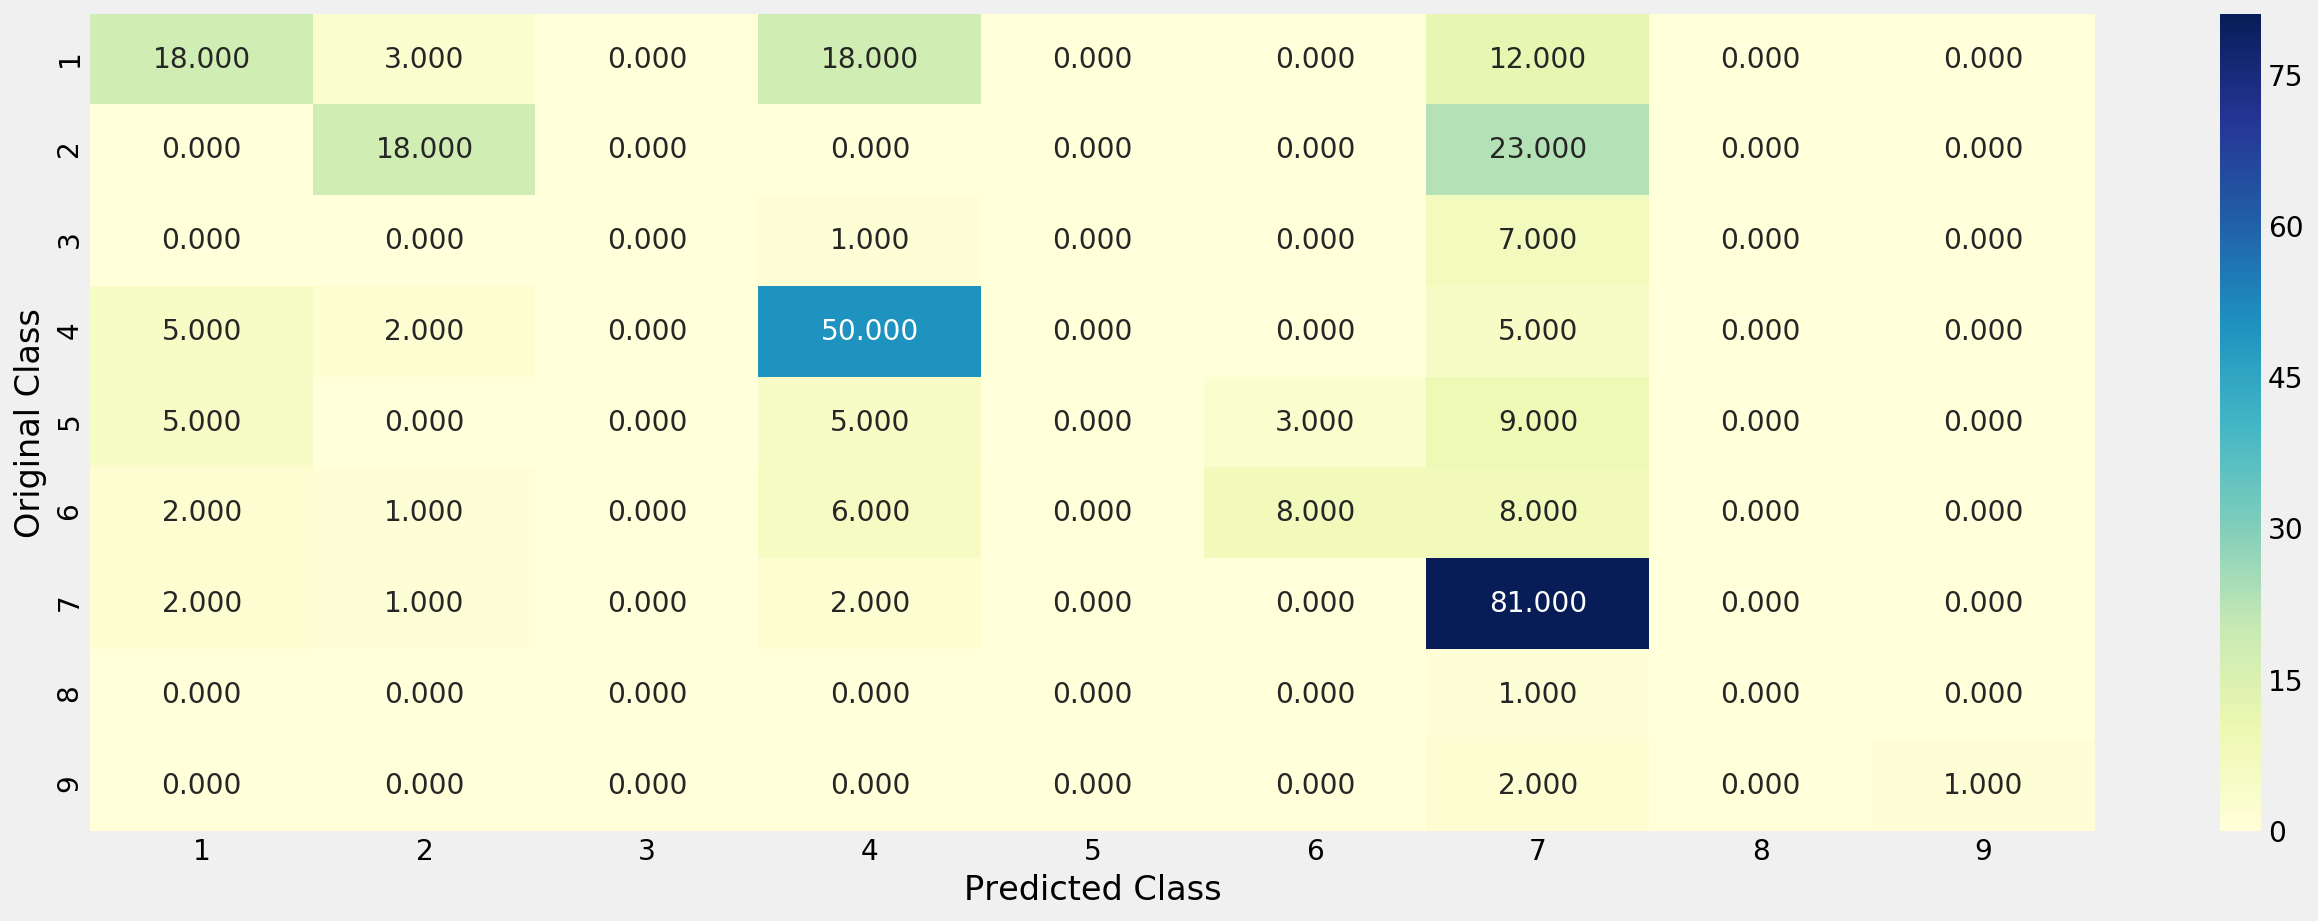

-------------------- Precision matrix (Columm Sum=1) --------------------


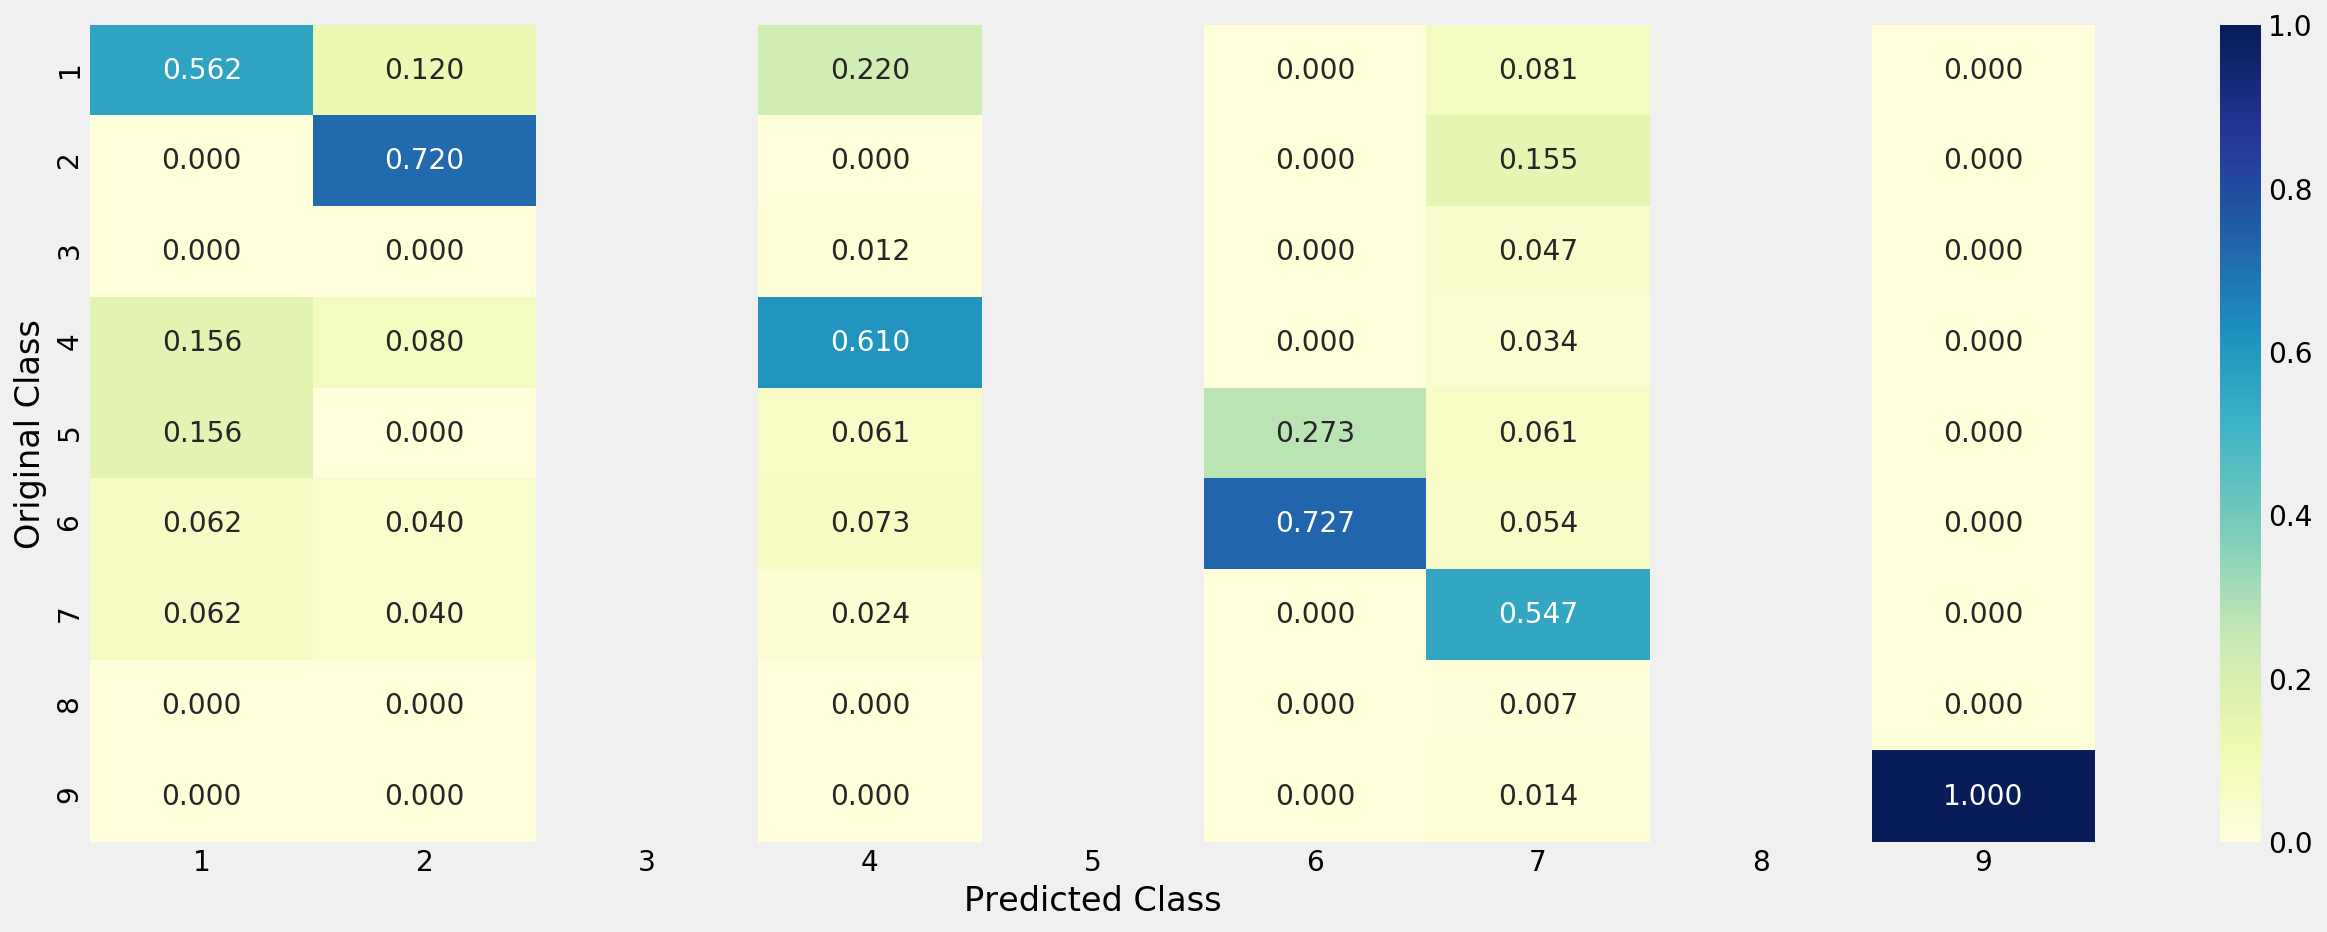

-------------------- Recall matrix (Row sum=1) --------------------


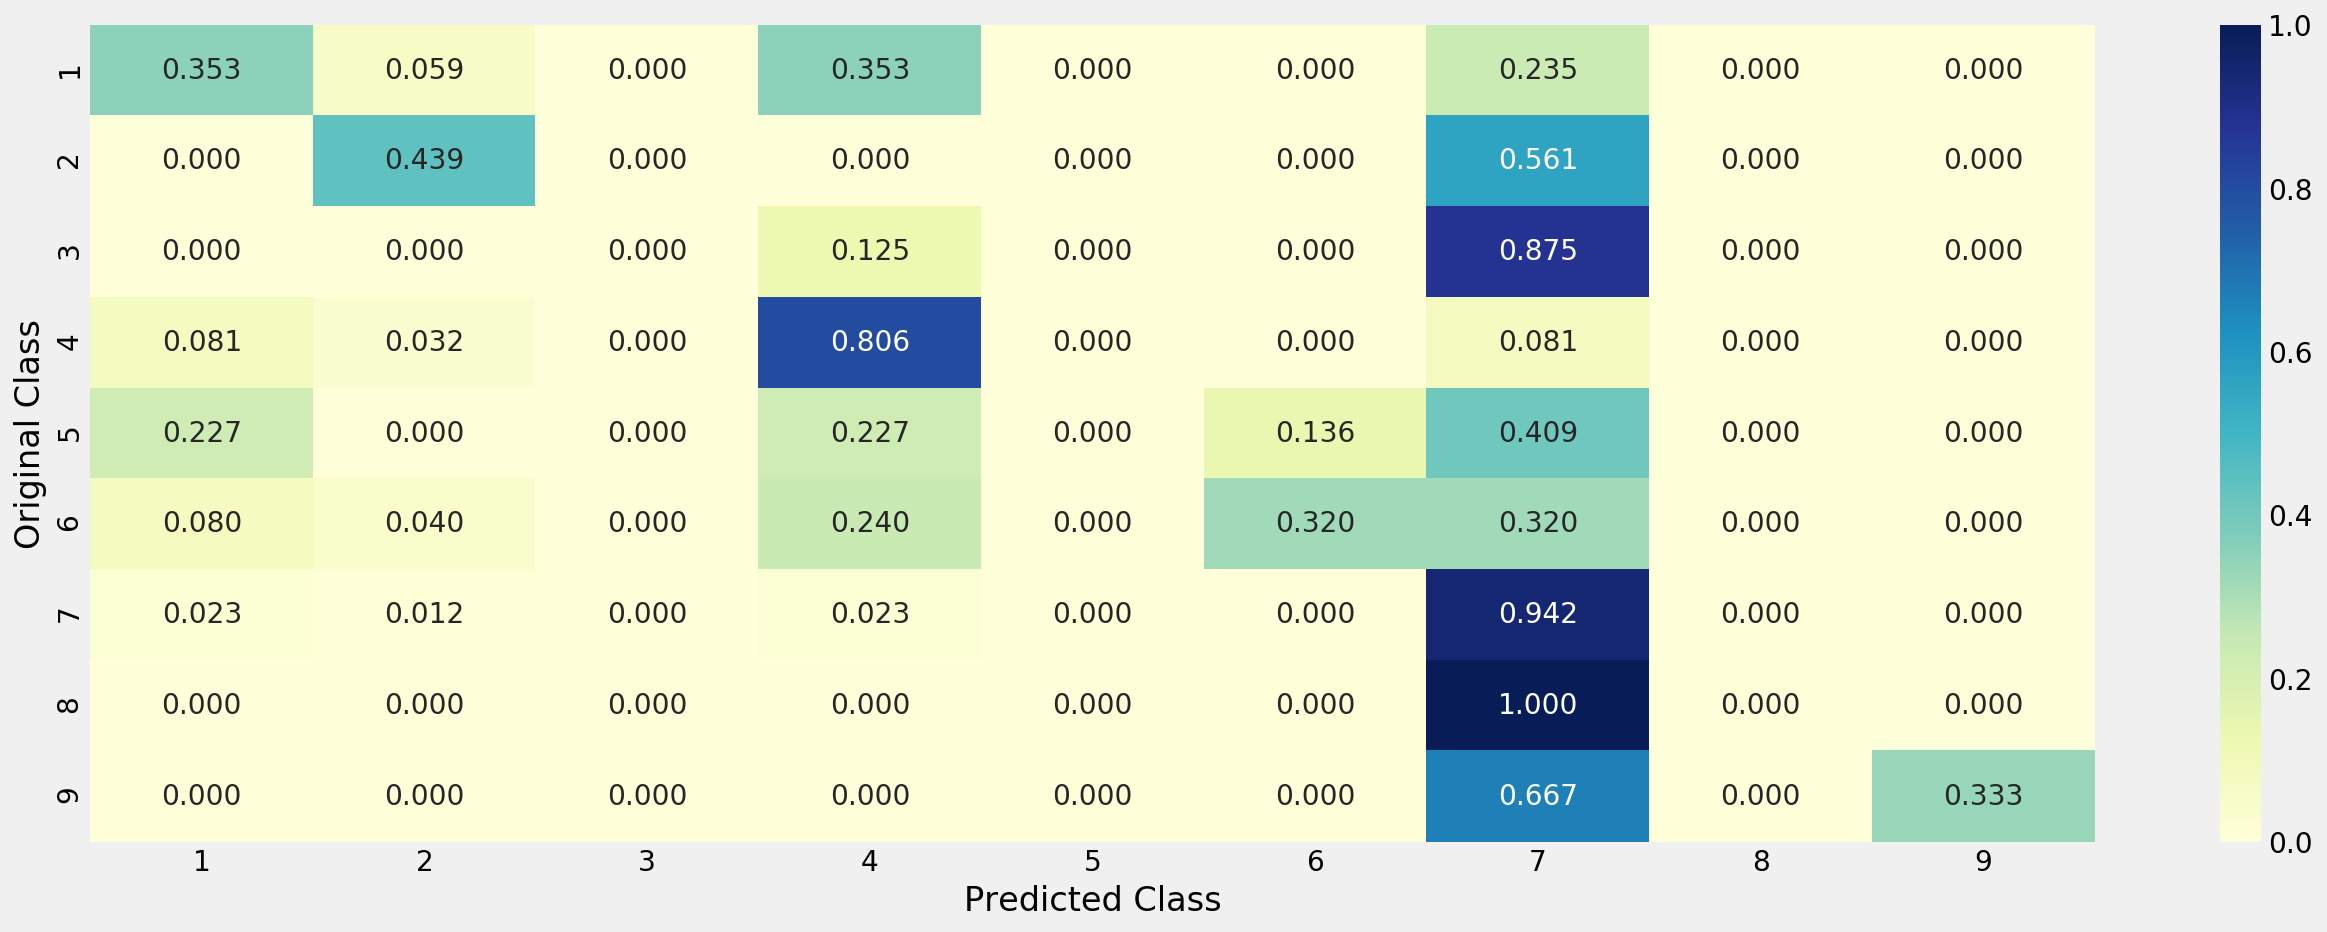

In [62]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x, train_y, cv_x, cv_y, clf)